In [1]:
import random
import random
import string
import numpy as np
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)
import copy
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import pylab as pl
from sklearn import metrics
from sklearn.model_selection import KFold
import os 
import seaborn as sns
random.seed(10)



def get_num(a, b, x):
    """
    gets a unique number between a range (a,b), divisible by x
    input:  a - start inde
            b - end index
            x = random number should be divisible by x
    return:
        random number divisible by x
    """
    if not a % x:
        return random.choice(range(a, b, x))
    else:
        return random.choice(range(a + x - (a % x), b, x))

def motif_string():
    """
    generates a string of length (by get_num) of ACGT
    returns: string of equal ACGT
    """
    length = 288
    # print("random length: " , length)
    len4 = length / 4
    # print("len / 4 :" , len4)
    letters = ["A", "C", "G", "T"]
    letters_list = list(random.choice(letters))
    random.shuffle(letters_list)
    # print(" Random generated string with repetition:")
    str1 = ""
    return str1.join(letters_list)

def non_motif_string(length):
    """
    generates a string of length (by get_num) of ACGT
    returns: string 
    """
    # print("random length: " , length)
    #len4 = length / 4
    # print("len / 4 :" , len4)
    letters = ["A", "C", "G", "T"]
    nonmotiflist = []
    for i in range(length): 
      nonmotiflist.append(random.choice(letters))
    # print(" Random generated string with repetition:")
    str1 = ""
    return str1.join(nonmotiflist)

def add_motif():
    """
    adds a motif - string input, to output by non_motif_string
    returns: string consisting of a motif
    """
    motif = 'ATACGTTACCCG'
    result = list(motif_string())
    i = random.choice(range(len(result)))
    result.insert(i, motif)
    result = "".join(result)
    return result,i


def write_to_df(length,var): #to generate non motif background files
  l=[]
  for i1 in range(int(length)):
    l1=[]
    i=-5
    result= non_motif_string(var)
    seq = "seq_" + str(i1 + 1) + "_peak"
    a='0'      
    l1 = ["A",seq,str(i), result,a]
    l.append(list(l1))
  df = pd.DataFrame(l,columns=['FoldID',	'EventID',	'start_index',	'seq',	'Bound']) 
  return df


def read_pfm_jaspar(filepath_):
  with open(Path(filepath_)) as f:
    lines = f.readlines()

  a = []
  for i in range(1,5,1):
    b = list(lines[i].split()[2:-1])
    a.append(b)
  a = np.array(a,dtype=float)
  return a

def convert_pfm_to_ppm(pfm):
  for i in range(pfm.shape[1]):
    sum = 0
    for j in range(pfm.shape[0]):
      sum+= pfm[j][i] 
    for j in range(pfm.shape[0]):
      prob = float(pfm[j][i]/sum)
      ppm[j][i] = float(prob)
  return(ppm)
  
p1=['A','C','G','T']
str1=''
def ppm_to_motif(ppm):
  motif = []
  mot=[]
  for i in range(ppm.shape[1]):
    arr = []
    for j in range(ppm.shape[0]):
      arr.append(float(ppm[j][i]))
    choice = np.random.choice(p1,p=arr) #motif is generated here
    mot.append(choice)
  
  return (''.join(mot))

def non_motif_create(df1,df2): #to implant a  motif in a non motif file -> 1. motif file, 2. mixed file 
  mot=[]
  l1=[]
  l2=[]
  for i in range(0,len(df1)):
    motif = ppm_to_motif(ppm)
    mot.append(motif)
    index=random.randint(0,len(df1[i])-1) #0 to 300 
    l1.append(index)
    df1[i]=df1[i][:index] + str(motif) + df1[i][index:]
    
    index2=np.random.choice(len(df2[i]))
    l2.append(index2)
    df2[i]=df2[i][:index2] + str(motif) + df2[i][index2:]
    #print(index)
    #print(df1[i])
    #print(mot)
  return l1,l2,df1,df2,mot #l1, l2 to store the index

def markov_model_motif(df1):
    """
    for a second degree motif markov model 
    returns dict2, dict3: count of the appearance of eg: A->C and eg: AC->T occuring
    """
    dict2, dict3 = {}, {}
    for j in range(len(df1)):
      seq = df1[j]
      for i in range(len(seq)-var): #dict2
        if seq[i:i+var] not in dict2: 
          dict2[seq[i:i+var]] = 1
        else: 
          dict2[seq[i:i+var]] += 1

      for i in range(len(seq)-var): #dict3
        if seq[i:i+var+1] not in dict3: 
          dict3[seq[i:i+var+1]] = 1
        else: 
          dict3[seq[i:i+var+1]] += 1

    #print('dict2: ', dict2)
    #print('dict3: ', dict3)
      
    return dict2, dict3

def motif_score1(dict2, dict3, seq):
    """
    returns the score of th markov model motif 
    """
    s = seq
    import math

    a=0
    sum = 0
    score = 1
    for i in range(0, len(s)):
      if s[i : i + var+1] not in dict3:
        #print("HELLOOOOOOOOOOOO", s[i : i + var+1])
        dict3[s[i : i + var+1]] = 1
      score = score * dict3[s[i : i + var+1]]
    #print('dict2-',dict2)
    #print('dict3-',dict3)
    return math.log(score),dict2,dict3

def motif_score(dict2, dict3, seq):
    """
    returns the score of th markov model motif 
    """
    s = seq
    import math
    score = 0
    ep=0.01
    for i in range(0, len(s)):
      if s[i : i + var+1] not in dict3:
        #print("HELLOOOOOOOOOOOO", s[i : i + var+1])
        dict3[s[i : i + var+1]] = ep
      else:
        dict3[s[i : i + var+1]] = dict3[s[i : i + var+1]] + ep
      score = score + math.log(dict3[s[i : i + var+1]])

    #print('dict2-',dict2)
    #print('dict3-',dict3)
    return score,dict2,dict3

def train(df,df2,df4):
  """
  df = for the motif markov model - seq 
  df2 = for the non motif markov model  - seq 
  df4 = the test file - pass the entire thing = seq + bound 
  Returns: the final dictionaries
  """
    # df1 = df['seq']
  #dict2, dict3 = {}, {}
  #dict2non, dict3non = {}, {}
   
  dict2, dict3 = markov_model_motif(df)  # markov model for the motif.txt file
  # print("####################################################")
  
  dict2_non, dict3_non = markov_model_motif(df2)  # markov model for the non motif file
  # now, testing each sequence and predicting their class using the 2 dictionaries

  for i in range(len(df4)):
      list1 = []
      list2 = []
  for i in range(len(df4)):
      seq = df4["seq"][i]
      """
      1. score it using ddict3
      2. score it using dict3_non 
      3. whichever score higher, give value of that class 
      4. add seq, class to a list, append that list to the df 
      5. write this file 
      """

      score_motif,dict5,dict6 = motif_score(dict2, dict3, seq)
      score_nonmotif,dict7,dict8 = motif_score(dict2_non, dict3_non, seq)
      #print('for sequence: ', seq, 'score motif: ', score_motif, 'score_nonmotif: ', score_nonmotif)
      list1.append(score_motif-score_nonmotif)
      if score_motif > score_nonmotif:
          list2.append(1)
      else:
          list2.append(0)
  df4["predicted"] = list2
  df4["log odd score"] = list1
  print(df4)
  if score_motif > score_nonmotif:
    return dict6
  else:
    return dict8

  #print('dict2 - motif: ', dict5)
  #print('dict3 - motif : ', dict6)
 
def accuracy(df4):
    y_true = df4["Bound"]
    y_pred = df4["predicted"]
    return accuracy_score(y_true, y_pred)

def acc_score(df4):
  y_true=df4['Bound']
  y_pred=df4['predicted']
  accuracy_score(y_true, y_pred)
  return y_true, y_pred



def confusion_mat(y_true,y_pred):
  array3=confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(5,5))   
  sns.heatmap(array3, annot=True,fmt='.2f',cmap="PuBu")
  plt.title('Confusion Matrix',fontsize=15,color='red')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


def auc_calculate(df4):
  y_log_score = df4['log odd score']
  precision, recall, thresholds = precision_recall_curve(y_true, y_log_score)
  area = auc(recall, precision)
  print("Area Under Curve")
  print(area)

  pl.clf()
  pl.plot(recall, precision, label='Precision-Recall curve')
  pl.xlabel('Recall')
  pl.ylabel('Precision')
  pl.ylim([0.0, 1.0])
  pl.xlim([0.0, 1.0])
  pl.title('Precision-Recall example: AUC=%0.2f' % area)
  pl.legend(loc="lower left")
  pl.show()

def roc_calculate(df4):
  y_log_score = df4['log odd score']
  fpr,tpr, thresh = metrics.roc_curve(y_true, y_log_score)
  auc = metrics.auc(fpr, tpr)
  print("AUC:", auc)

  plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid()
  plt.legend()
  plt.show()



df_nonmotif_train = write_to_df(1000,314)
df_mixed_motif = write_to_df(1000,300)
df_mixed_nonmotif = write_to_df(1000,314)
df_motif_train = write_to_df(1000,300)
print('###### PRINTING NON MOTIF TRAIN DATAFRAME ########')
print(df_nonmotif_train.head())

pfm = read_pfm_jaspar('/content/MA0003.4.jaspar')
print("##### PRINTING PFM #####")
print(pfm)
ppm = copy.deepcopy(pfm)
print("##### PRINTING PPM DEEPCOPY #####")
print(ppm)
ppm = convert_pfm_to_ppm(pfm)
print("##### PRINTING PPM  #####")
print(ppm)
motif= ppm_to_motif(ppm)
print("##### PRINTING ONE MOTIF  #####")
print(motif)

l1,l2,df_motif_train['seq'],df_mixed_motif['seq'],mot=non_motif_create(list(df_motif_train['seq']),list(df_mixed_motif['seq']))
print('##### l1 length #####')
print(l1)
print('##### len(df_motif_train[seq][0]) #####')
print(len(df_motif_train['seq'][0]))

df_motif_train['start_index'] = l1
df_mixed_motif['start_index'] = l2
df_motif_train['Bound']=df_motif_train['Bound'].astype('int32').replace(0,1)
df_mixed_motif['Bound']=df_mixed_motif['Bound'].astype('int32').replace(0,1)

#df_mixed_motif['Bound'].dtype
print('##### df_mixed_motif head #####')
print(df_mixed_motif.head())
df_mixed_motif=df_mixed_motif.append(df_mixed_nonmotif,ignore_index=True)
df_mixed=df_mixed_motif.sample(frac=1).reset_index(drop=True)
print('##### df mixed #####')
print(df_mixed.head())

path = Path('/content/test1')
if path.exists() == False:
    print('hello')
    os.mkdir(path)

df_mixed.to_csv(str(path) +'/mixed.txt',index=None, sep='\t')
df_motif_train.to_csv(str(path) +'/motif.txt',index=None, sep='\t')
df_nonmotif_train.to_csv(str(path) +'/nonmotif.txt',index=None, sep='\t')


###### PRINTING NON MOTIF TRAIN DATAFRAME ########
  FoldID     EventID start_index  \
0      A  seq_1_peak          -5   
1      A  seq_2_peak          -5   
2      A  seq_3_peak          -5   
3      A  seq_4_peak          -5   
4      A  seq_5_peak          -5   

                                                 seq Bound  
0  ATTACTTGCATGACGATCGTTGGTCGGCTCTTAACCCGGCGTTTAG...     0  
1  ACTCATATCGGACAATAATGCAGGTCACCGCCCTTACAAAACATAA...     0  
2  CTTCCGTCCACCATACGGTCTCTTTATACAAAGCGGGGCGCAATAT...     0  
3  CTCCAAGGACAAATCATTGAAACATGAGAGCCTCTGGCTATCTGCG...     0  
4  AAACGTTATTAAGTACTTCACGTTTCAAAACAATGGTGACGTTTTT...     0  
##### PRINTING PFM #####
[[ 4335.  2763.  2842.  1088.   280.   116.   278.   530. 13567.   186.
    154.  1221.  4220.  5204.]
 [ 4092.  4620.  2634.  3615. 15321. 15351.  1173. 13536.   739.   217.
    234.  9445.  4783.  3915.]
 [ 4072.  3374.  3791.  9961.   187.   212.   750.  1406.  1229. 15432.
  15422.  4098.  3051.  3841.]
 [ 3469.  5211.  6701.  1304.   

##### df head #####
Len of motif list:  1000
Len of non motif list:  1000
10
##### len(all_train_index_motif[0]) #####
900
##### len(all_train_index_motif) #####
10
##### len(all_train_index_nonmotif) #####
10
##### all_train_index_nonmotif[0] #####
900
##### all_test_index_nonmotif #####
10
##### all_test_index_motif[0]) #####
100
Step:  2
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          0   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          0   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          1   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          0   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          0   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          0   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACC

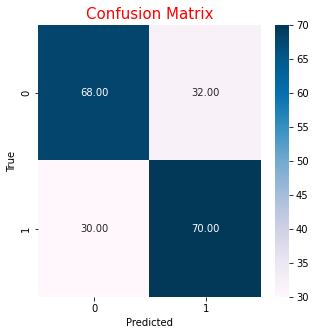

AUC: 0.7569


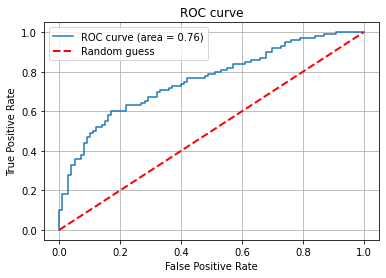

Step:  3
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          0   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          1   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          1   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          0   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          0   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          1   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACCTG...      1          1   
197  CCTTCGTTCTGGCGGGTTTATCTTGTTCACACTGCAGAAGGGTTCG...      0          1   
198  ACACGGGGGCTTGACCTTGGACCCAGGGAATTGCACCAGTAATTTT...      1          0   
199  TAATGGTAGAGGACGGGCGCGATCCGCTGTCTAGGTAACCCCTATT...      1          1   

     log odd score  
0        -1.241325  
1         1.169752  
2         5.084

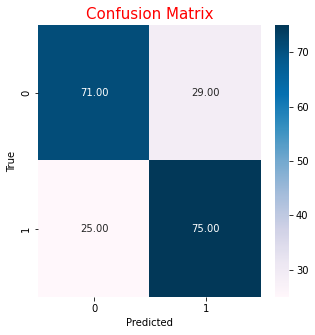

AUC: 0.8092000000000001


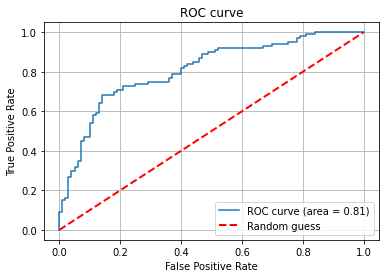

Step:  4
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          0   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          1   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          1   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          0   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          0   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          1   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACCTG...      1          1   
197  CCTTCGTTCTGGCGGGTTTATCTTGTTCACACTGCAGAAGGGTTCG...      0          0   
198  ACACGGGGGCTTGACCTTGGACCCAGGGAATTGCACCAGTAATTTT...      1          0   
199  TAATGGTAGAGGACGGGCGCGATCCGCTGTCTAGGTAACCCCTATT...      1          1   

     log odd score  
0        -2.381953  
1         1.522408  
2         8.853

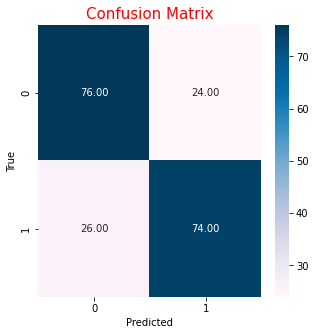

AUC: 0.819


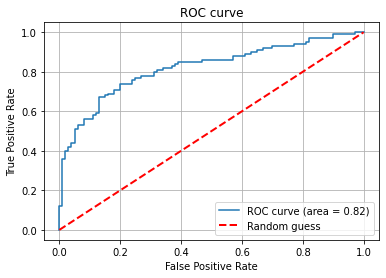

Step:  5
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          0   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          1   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          1   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          0   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          0   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          1   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACCTG...      1          1   
197  CCTTCGTTCTGGCGGGTTTATCTTGTTCACACTGCAGAAGGGTTCG...      0          0   
198  ACACGGGGGCTTGACCTTGGACCCAGGGAATTGCACCAGTAATTTT...      1          0   
199  TAATGGTAGAGGACGGGCGCGATCCGCTGTCTAGGTAACCCCTATT...      1          1   

     log odd score  
0        -1.308840  
1         8.286509  
2        17.812

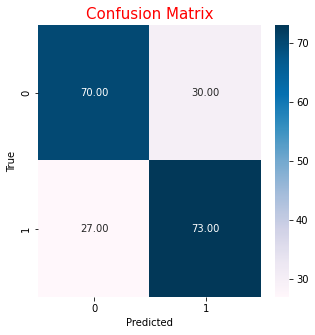

AUC: 0.8097000000000001


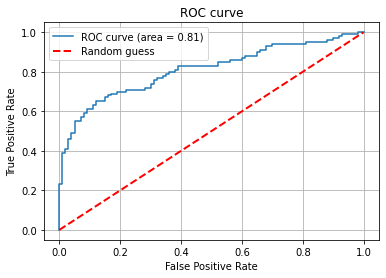

Step:  6
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          1   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          1   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          1   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          0   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          0   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          1   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACCTG...      1          1   
197  CCTTCGTTCTGGCGGGTTTATCTTGTTCACACTGCAGAAGGGTTCG...      0          0   
198  ACACGGGGGCTTGACCTTGGACCCAGGGAATTGCACCAGTAATTTT...      1          0   
199  TAATGGTAGAGGACGGGCGCGATCCGCTGTCTAGGTAACCCCTATT...      1          0   

     log odd score  
0         1.233899  
1        19.243739  
2        23.699

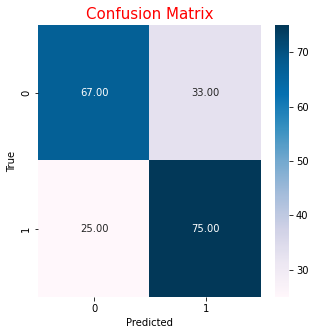

AUC: 0.7899


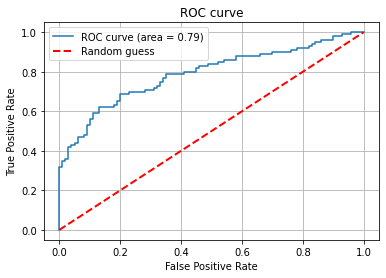

Step:  7
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          1   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          1   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          1   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          0   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          0   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          1   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACCTG...      1          1   
197  CCTTCGTTCTGGCGGGTTTATCTTGTTCACACTGCAGAAGGGTTCG...      0          0   
198  ACACGGGGGCTTGACCTTGGACCCAGGGAATTGCACCAGTAATTTT...      1          0   
199  TAATGGTAGAGGACGGGCGCGATCCGCTGTCTAGGTAACCCCTATT...      1          0   

     log odd score  
0         0.047204  
1        28.748310  
2        67.203

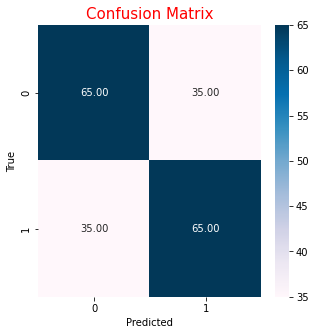

AUC: 0.7134


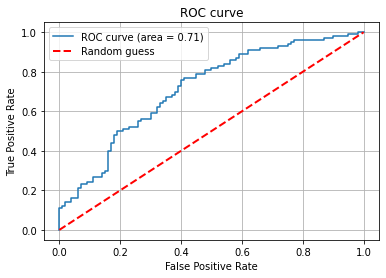

Step:  8
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          1   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          1   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          1   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          0   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          1   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          1   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACCTG...      1          1   
197  CCTTCGTTCTGGCGGGTTTATCTTGTTCACACTGCAGAAGGGTTCG...      0          0   
198  ACACGGGGGCTTGACCTTGGACCCAGGGAATTGCACCAGTAATTTT...      1          0   
199  TAATGGTAGAGGACGGGCGCGATCCGCTGTCTAGGTAACCCCTATT...      1          0   

     log odd score  
0        59.238985  
1        76.418049  
2        81.949

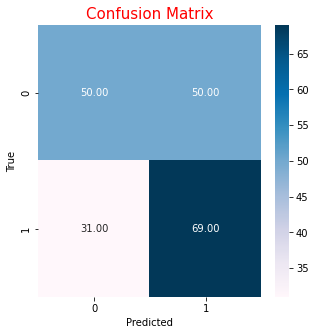

AUC: 0.615


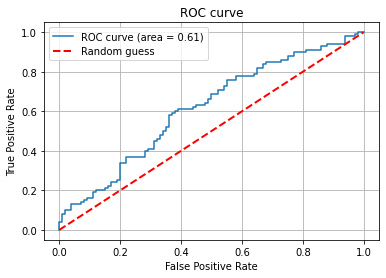

Step:  9
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          1   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          1   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          1   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          1   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          0   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          1   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACCTG...      1          1   
197  CCTTCGTTCTGGCGGGTTTATCTTGTTCACACTGCAGAAGGGTTCG...      0          0   
198  ACACGGGGGCTTGACCTTGGACCCAGGGAATTGCACCAGTAATTTT...      1          0   
199  TAATGGTAGAGGACGGGCGCGATCCGCTGTCTAGGTAACCCCTATT...      1          0   

     log odd score  
0        68.052609  
1       130.851873  
2        88.343

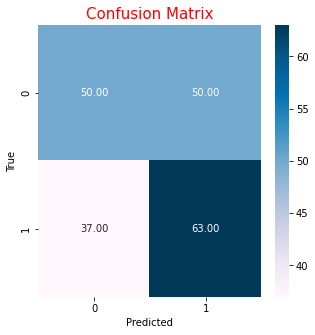

AUC: 0.6064


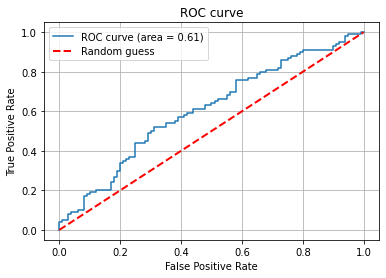

Step:  10
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          1   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          1   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          1   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          0   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          0   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          1   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACCTG...      1          1   
197  CCTTCGTTCTGGCGGGTTTATCTTGTTCACACTGCAGAAGGGTTCG...      0          1   
198  ACACGGGGGCTTGACCTTGGACCCAGGGAATTGCACCAGTAATTTT...      1          1   
199  TAATGGTAGAGGACGGGCGCGATCCGCTGTCTAGGTAACCCCTATT...      1          0   

     log odd score  
0        32.994028  
1        73.244490  
2        84.64

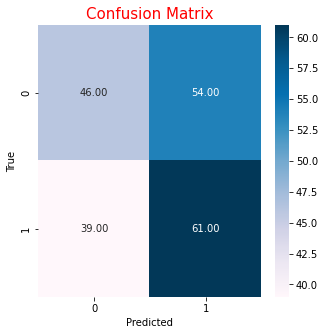

AUC: 0.5905


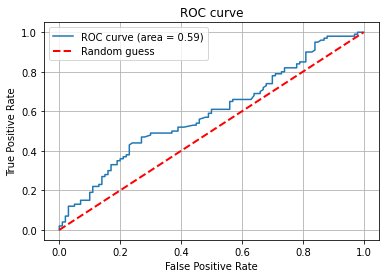

Step:  11
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          1   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          1   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          1   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          0   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          0   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          1   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACCTG...      1          1   
197  CCTTCGTTCTGGCGGGTTTATCTTGTTCACACTGCAGAAGGGTTCG...      0          0   
198  ACACGGGGGCTTGACCTTGGACCCAGGGAATTGCACCAGTAATTTT...      1          0   
199  TAATGGTAGAGGACGGGCGCGATCCGCTGTCTAGGTAACCCCTATT...      1          0   

     log odd score  
0        18.460482  
1        39.793128  
2        56.75

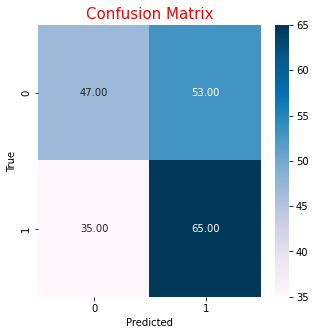

AUC: 0.61385


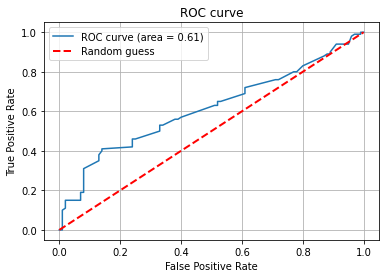

Step:  12
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          1   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          1   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          1   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          0   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          0   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          1   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACCTG...      1          1   
197  CCTTCGTTCTGGCGGGTTTATCTTGTTCACACTGCAGAAGGGTTCG...      0          0   
198  ACACGGGGGCTTGACCTTGGACCCAGGGAATTGCACCAGTAATTTT...      1          0   
199  TAATGGTAGAGGACGGGCGCGATCCGCTGTCTAGGTAACCCCTATT...      1          0   

     log odd score  
0         4.615121  
1        14.533546  
2        18.46

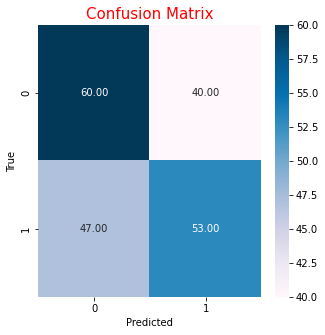

AUC: 0.585


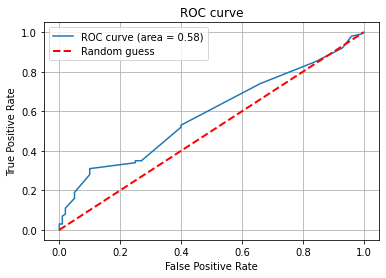

Step:  13
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          0   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          1   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          0   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          0   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          0   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          1   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACCTG...      1          1   
197  CCTTCGTTCTGGCGGGTTTATCTTGTTCACACTGCAGAAGGGTTCG...      0          0   
198  ACACGGGGGCTTGACCTTGGACCCAGGGAATTGCACCAGTAATTTT...      1          0   
199  TAATGGTAGAGGACGGGCGCGATCCGCTGTCTAGGTAACCCCTATT...      1          0   

     log odd score  
0         0.000000  
1         9.230241  
2         0.00

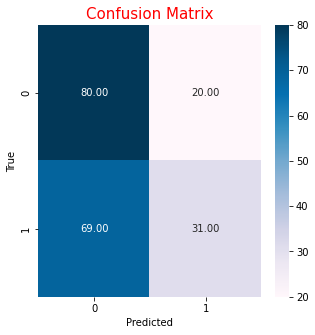

AUC: 0.5477999999999998


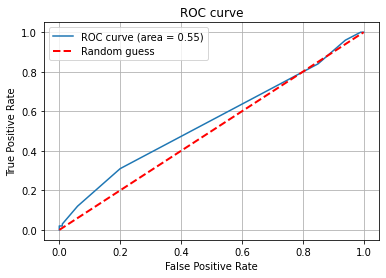

Step:  14
                                                   seq  Bound  predicted  \
0    ATCTATTTTTCCTAGATACACTACAACGTATGTTCTACATACATGC...      0          0   
1    AGTCCCGGGGCCATAATATGTCTGGTGTAAGCACCCACCTGCCCCC...      1          1   
2    GTTCGTTCCCGGGTACAGAGCTAATCACCGCAATACACAGTTGGTT...      1          0   
3    GAGCGTCATTCGAAGAAAGTTATTTGTATCTGCCTGCAGGTGCATA...      0          0   
4    AGACCTAGAAGGCCAGAAGGTCCCGTGAGCCCTCATATGTCGAGTG...      0          0   
..                                                 ...    ...        ...   
195  CGGAAGAATCGTGCAGCGCACCTCGACTACCATCAGCACCCCCACG...      1          1   
196  TTAAGTAAACCGATAGGTGGTGGGCGCTCATGCGCAAAGGGACCTG...      1          1   
197  CCTTCGTTCTGGCGGGTTTATCTTGTTCACACTGCAGAAGGGTTCG...      0          0   
198  ACACGGGGGCTTGACCTTGGACCCAGGGAATTGCACCAGTAATTTT...      1          0   
199  TAATGGTAGAGGACGGGCGCGATCCGCTGTCTAGGTAACCCCTATT...      1          0   

     log odd score  
0         0.000000  
1         4.615121  
2         0.00

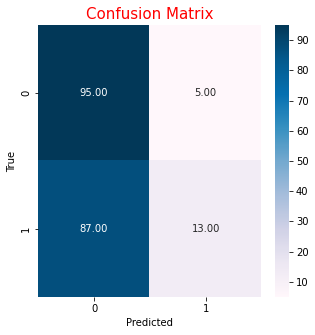

AUC: 0.55625


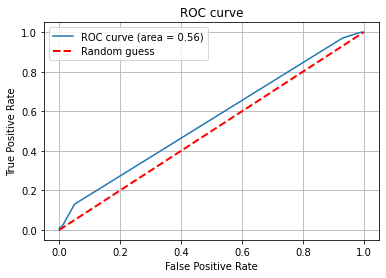

Step:  2
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          1   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          0   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          1   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          1   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          0   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          0   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          1   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          0   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          1   

     log odd score  
0         0.286063  
1         0.644804  
2        -2.015

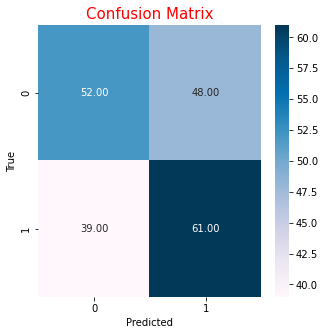

AUC: 0.5614999999999999


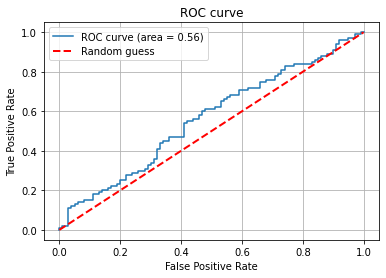

Step:  3
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          1   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          0   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          1   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          1   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          0   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          1   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          1   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          1   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          1   

     log odd score  
0         0.972276  
1         2.705363  
2        -3.463

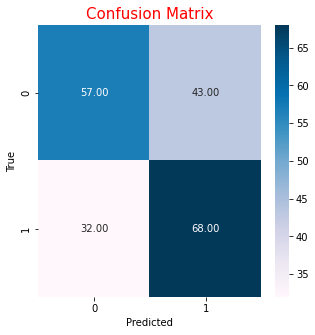

AUC: 0.6638


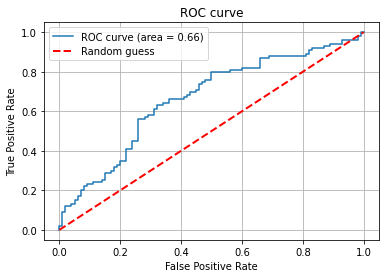

Step:  4
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          1   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          0   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          1   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          1   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          0   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          1   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          1   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          1   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          1   

     log odd score  
0         3.038091  
1         5.190807  
2        -4.605

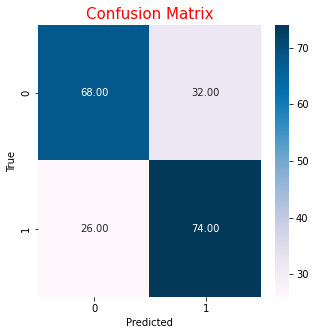

AUC: 0.7686999999999999


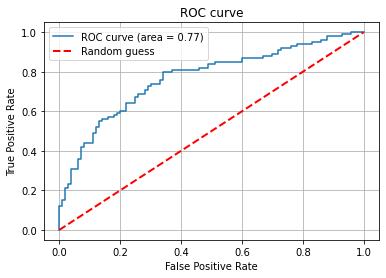

Step:  5
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          1   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          0   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          1   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          1   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          0   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          1   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          1   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          1   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          1   

     log odd score  
0         5.560223  
1        11.684147  
2        -8.885

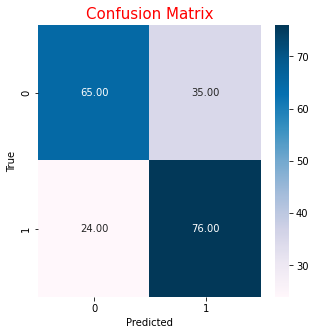

AUC: 0.7998000000000001


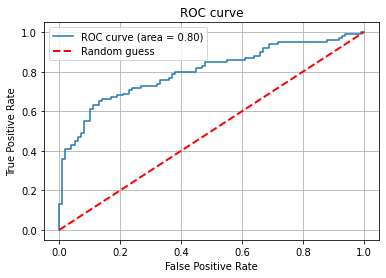

Step:  6
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          1   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          0   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          1   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          1   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          1   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          1   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          1   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          1   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          1   

     log odd score  
0        13.058922  
1        17.213534  
2        -5.334

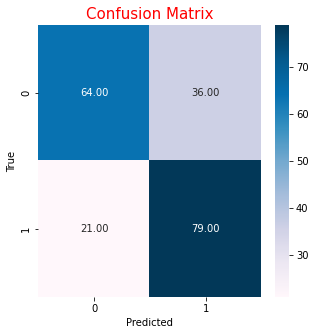

AUC: 0.7968999999999999


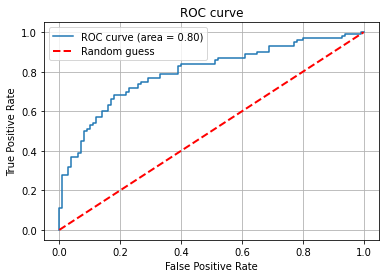

Step:  7
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          1   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          0   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          1   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          1   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          1   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          1   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          1   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          1   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          1   

     log odd score  
0        49.309512  
1        35.502165  
2        -5.037

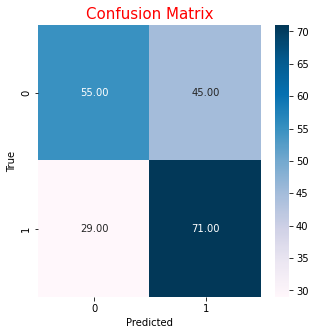

AUC: 0.6918


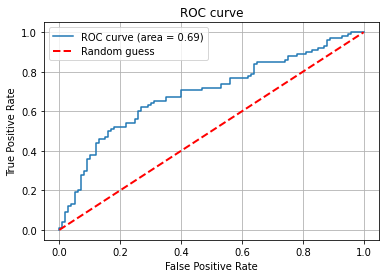

Step:  8
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          1   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          0   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          1   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          1   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          1   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          1   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          1   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          1   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          1   

     log odd score  
0        81.926202  
1        35.335409  
2      -111.621

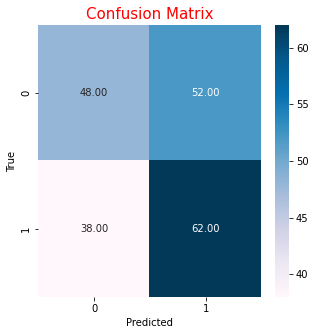

AUC: 0.6022


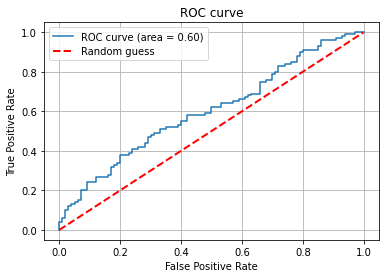

Step:  9
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          1   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          0   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          1   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          1   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          1   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          1   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          1   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          1   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          1   

     log odd score  
0        65.015493  
1        83.200761  
2       -60.969

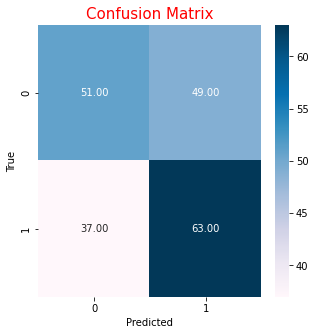

AUC: 0.6241


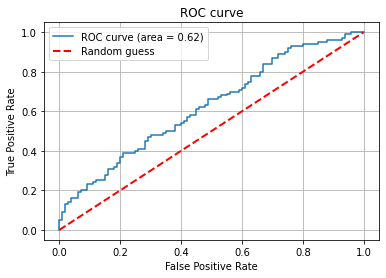

Step:  10
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          1   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          0   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          1   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          1   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          1   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          1   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          1   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          1   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          1   

     log odd score  
0        17.772298  
1        32.030073  
2        -3.92

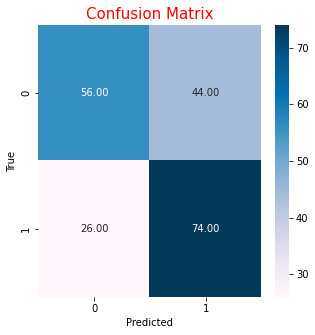

AUC: 0.6755


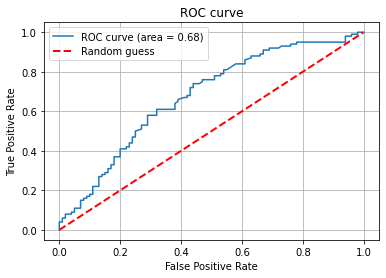

Step:  11
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          0   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          1   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          1   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          1   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          1   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          0   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          1   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          1   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          1   

     log odd score  
0        -9.230241  
1        27.411099  
2        13.84

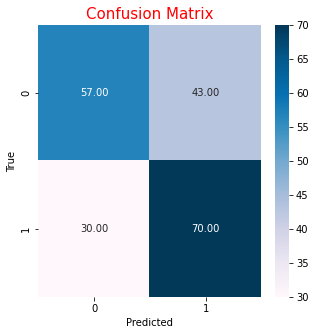

AUC: 0.68675


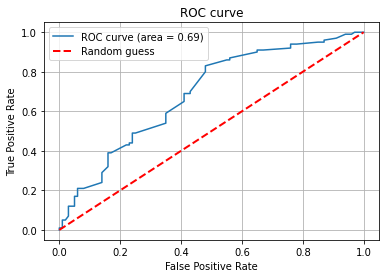

Step:  12
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          0   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          1   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          1   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          0   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          1   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          0   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          0   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          1   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          1   

     log odd score  
0        -9.230241  
1        26.232146  
2         4.61

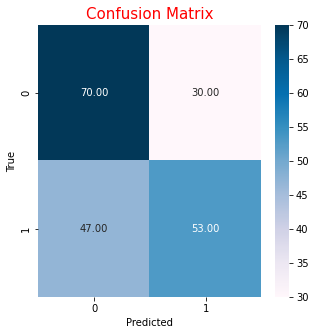

AUC: 0.6842


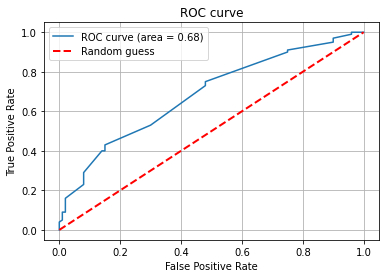

Step:  13
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          0   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          1   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          0   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          0   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          0   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          0   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          0   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          1   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          0   

     log odd score  
0        -4.615121  
1        18.460482  
2         4.61

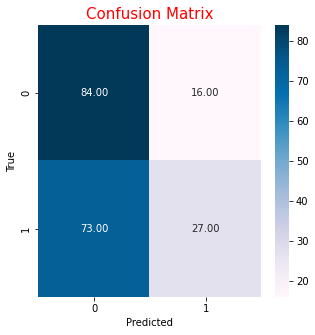

AUC: 0.5651499999999999


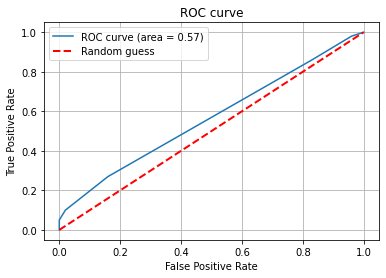

Step:  14
                                                   seq  Bound  predicted  \
0    CTATTCAGGTGAAGAAAAAGTTGTGATATGGCCGTCTACATCCTCT...      1          0   
1    GTTTCATAAGCCTCATAGCGACCCAACCTATCTTTGCGCAGGTGTC...      1          1   
2    GTAGTCGTTGACGGCGATGGCGTCGCGACTGGCTGGATCTAATTTG...      0          0   
3    CGGCGCGCTGTGCAGTACTTGCCCTGTTTGAGATTGATGGGAATAA...      1          0   
4    TACCAAATAGCATCGCTCGAAAAGCTACGGATGAAGGCCGAAACGC...      0          0   
..                                                 ...    ...        ...   
195  TCCTAGGATTCGGCTTGAGTGCCGTTCATCGTTCATCCGGTTTAGC...      0          0   
196  CATACATGTTTCAGCTCGGTTCGTGAGTGCAGTGTAATAGATGCAG...      1          0   
197  TTTCGGACAAGAAAGGTAGTAACGGCATTGGCTGCACGATACCCGG...      1          0   
198  AATAATGATGAAAAGCGAGTGCATTTCCATTCATTGTACTTTTTCA...      1          0   
199  GACCATCATCAGTAACCGATTCCCAAGGCGGTTTCGGTGTCATTCC...      1          0   

     log odd score  
0         0.000000  
1         4.615121  
2         0.00

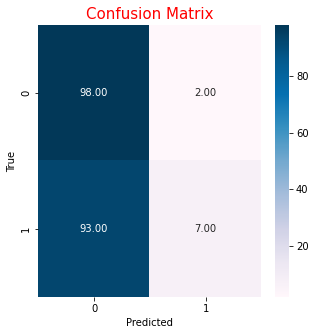

AUC: 0.53845


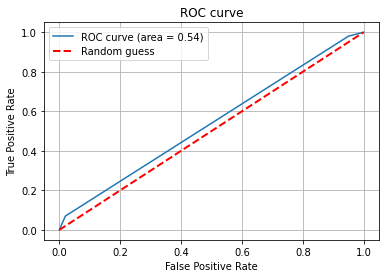

Step:  2
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          0   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          1   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          0   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          1   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          0   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          1   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          1   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          1   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          1   

     log odd score  
0        -0.896667  
1         0.721201  
2        -0.810

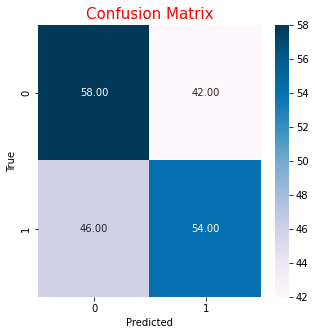

AUC: 0.6153000000000001


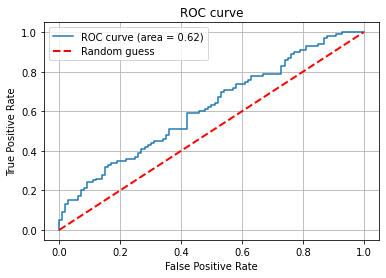

Step:  3
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          1   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          0   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          0   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          1   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          0   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          1   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          0   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          1   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          0   

     log odd score  
0         0.043285  
1        -0.097644  
2        -1.849

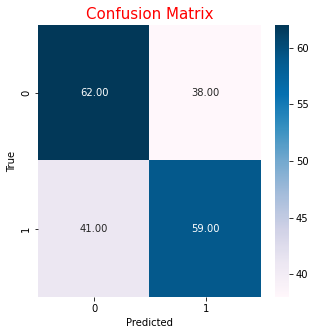

AUC: 0.65


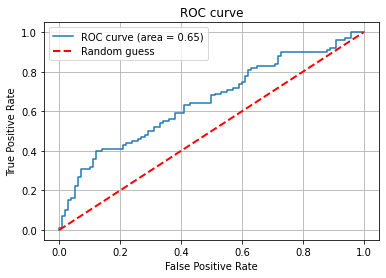

Step:  4
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          1   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          0   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          0   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          1   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          0   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          1   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          0   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          1   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          0   

     log odd score  
0         2.678196  
1        -2.530246  
2        -2.157

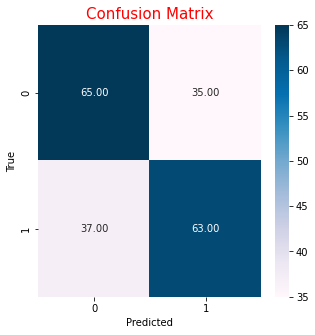

AUC: 0.6995


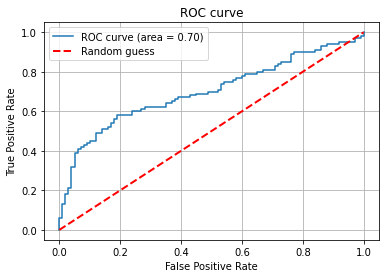

Step:  5
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          1   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          0   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          0   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          0   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          1   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          1   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          0   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          1   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          0   

     log odd score  
0         7.977266  
1        -4.779494  
2        -3.317

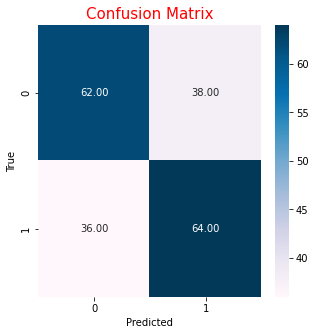

AUC: 0.6841999999999999


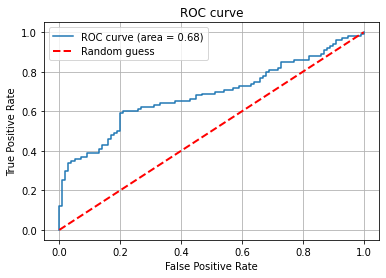

Step:  6
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          1   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          0   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          1   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          0   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          1   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          1   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          0   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          1   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          0   

     log odd score  
0         4.559271  
1        -1.350886  
2         2.630

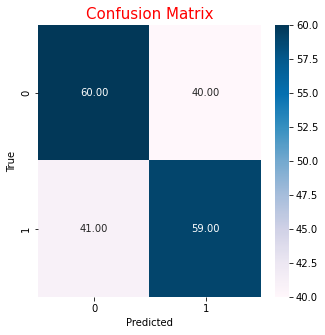

AUC: 0.6412


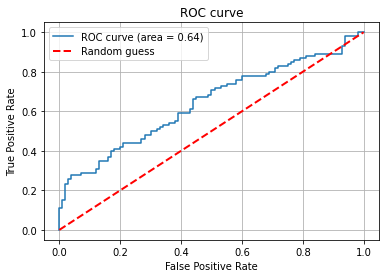

Step:  7
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          1   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          1   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          1   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          0   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          1   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          1   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          0   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          0   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          0   

     log odd score  
0         4.836659  
1        13.907242  
2         2.373

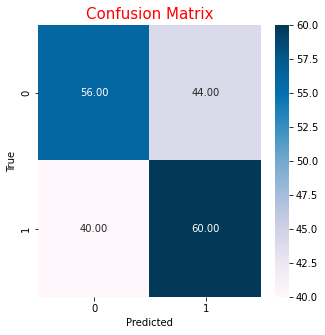

AUC: 0.6228


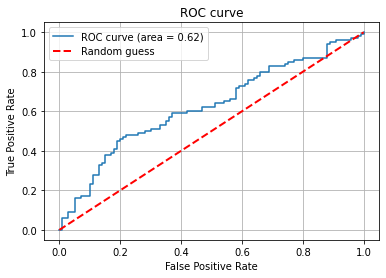

Step:  8
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          0   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          1   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          0   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          1   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          1   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          1   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          0   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          0   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          0   

     log odd score  
0       -23.395612  
1       110.653091  
2       -67.009

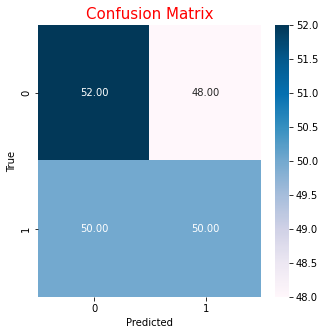

AUC: 0.5553


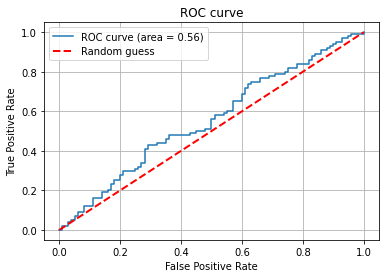

Step:  9
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          0   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          1   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          1   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          1   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          1   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          1   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          0   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          1   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          0   

     log odd score  
0       -18.135329  
1        31.335752  
2        52.427

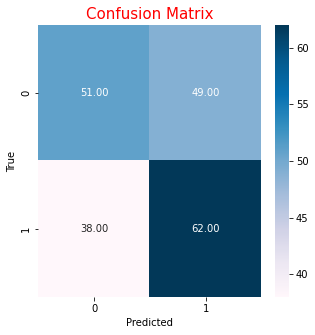

AUC: 0.5714


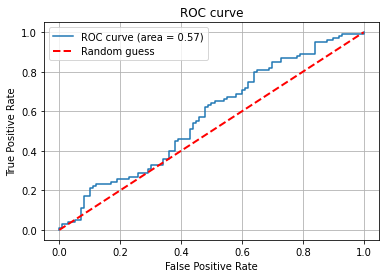

Step:  10
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          1   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          0   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          1   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          1   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          0   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          1   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          1   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          1   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          0   

     log odd score  
0        23.091345  
1        -8.138251  
2        56.06

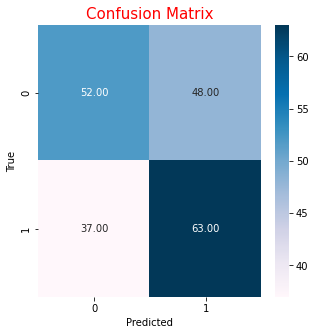

AUC: 0.6166999999999999


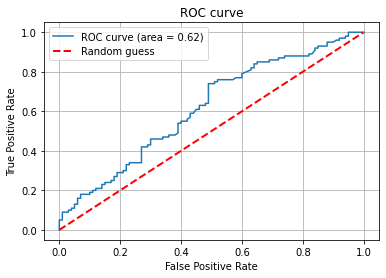

Step:  11
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          1   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          1   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          1   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          1   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          0   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          0   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          1   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          1   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          0   

     log odd score  
0        15.221730  
1         4.615121  
2        27.69

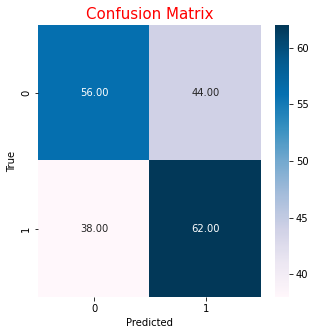

AUC: 0.6091


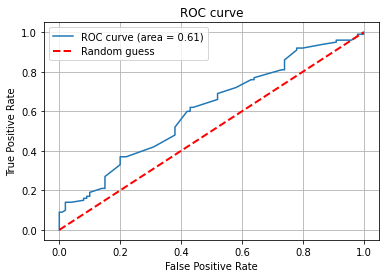

Step:  12
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          1   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          0   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          0   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          1   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          0   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          0   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          1   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          1   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          0   

     log odd score  
0         4.615121  
1         0.000000  
2         0.00

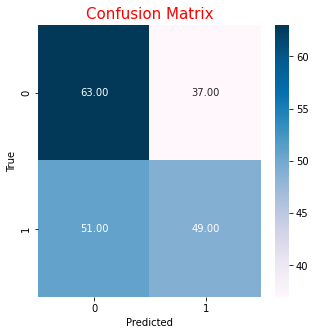

AUC: 0.5794999999999999


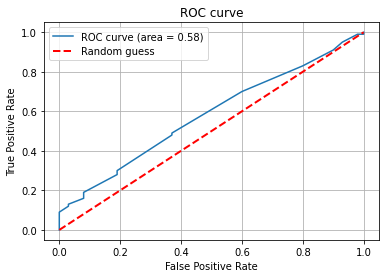

Step:  13
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          0   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          0   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          0   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          0   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          0   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          0   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          1   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          0   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          0   

     log odd score  
0         0.000000  
1         0.000000  
2         0.00

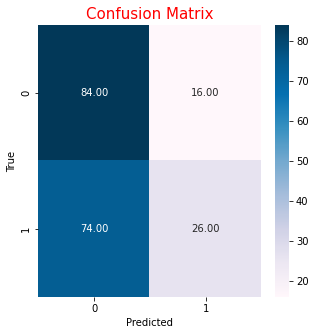

AUC: 0.54475


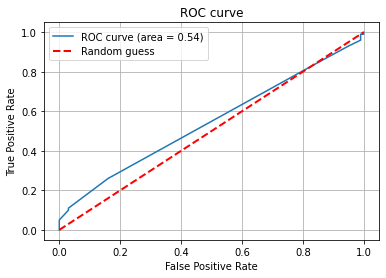

Step:  14
                                                   seq  Bound  predicted  \
0    TGTATGGTAGATACTATACGGGCCTTCTTGTGGTGGATAGTATGTC...      1          0   
1    CCTCCTGGCAGCTACTAGAAGCACGAGGGCGAAGCTGAGTGAGAGC...      1          0   
2    GCGTAGATAAGATACGCTGTTGGACGTTACTTCTACACTTAAACAG...      1          0   
3    CCGAAACGGCGAGGAGTAGCCCTGATGAGTCGTTAGGTGAGGAAGC...      0          0   
4    CATTTTGCATGATTGTTATTCCATCGCACTCCGCCACAGGCTCTCC...      1          0   
..                                                 ...    ...        ...   
195  GGGACGCCTCAGGTGAGCGACGTTCGACAACCGCTCGTTCGAGCAT...      1          0   
196  AACGACATCCCTGGGTATTGTGTTTGTGCCCCTGAGACTTCTAAGT...      0          0   
197  ATATGCCGATTTTGTAAGACGGGTTAGGTTAGCTACGCCTGCCTTA...      1          0   
198  CAACCCCTCAGGCTAGGACGGATTCCTATATGAAACTCGTGGTCTC...      1          0   
199  TGACAAGCTAGCACGAATCAGGCGCAAGAAGAAGTGTCGCCATTCA...      0          0   

     log odd score  
0              0.0  
1              0.0  
2             

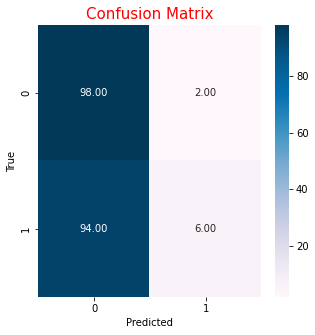

AUC: 0.50955


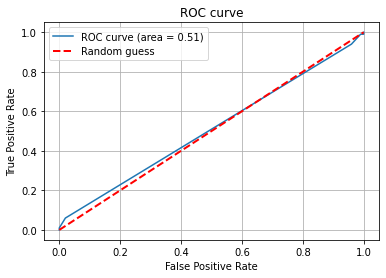

Step:  2
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          0   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          1   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          0   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          0   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          0   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          0   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          1   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          1   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          1   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          0   

     log odd score  
0        -0.624436  
1         0.550147  
2        -1.015

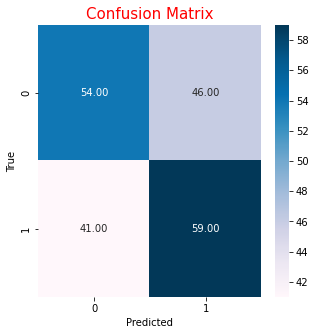

AUC: 0.6036000000000001


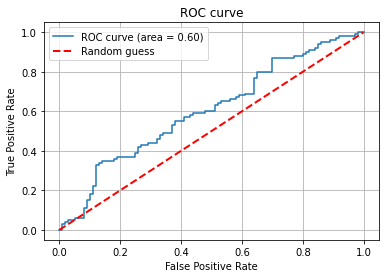

Step:  3
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          0   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          1   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          0   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          1   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          0   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          0   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          0   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          1   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          1   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          0   

     log odd score  
0        -1.380377  
1         2.140562  
2        -3.369

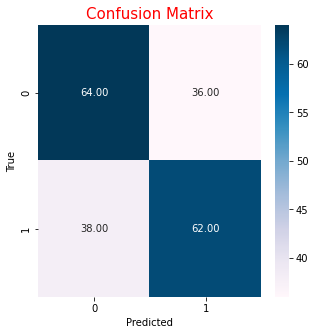

AUC: 0.6752000000000001


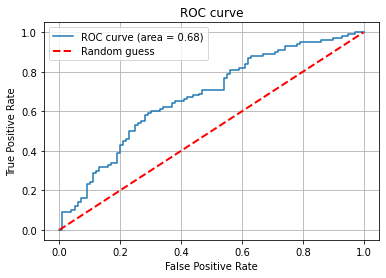

Step:  4
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          1   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          1   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          0   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          1   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          0   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          1   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          0   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          1   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          1   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          0   

     log odd score  
0         0.972115  
1         2.462021  
2        -3.787

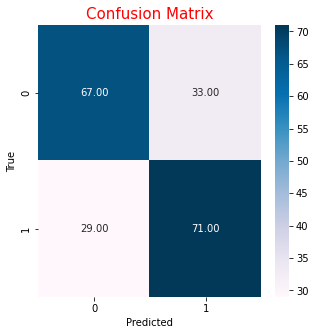

AUC: 0.726


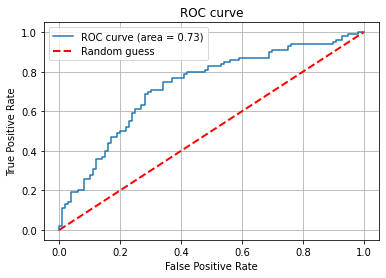

Step:  5
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          1   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          1   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          0   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          1   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          0   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          1   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          1   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          1   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          1   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          0   

     log odd score  
0         2.403100  
1         1.138547  
2        -4.772

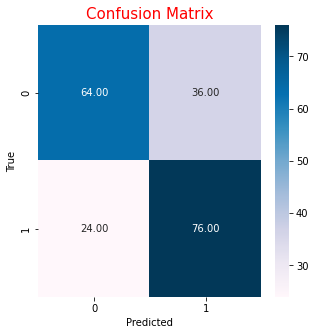

AUC: 0.7572999999999999


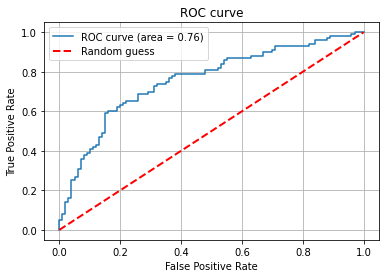

Step:  6
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          1   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          0   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          0   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          1   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          0   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          1   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          1   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          1   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          1   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          0   

     log odd score  
0         6.504257  
1        -1.394197  
2       -13.481

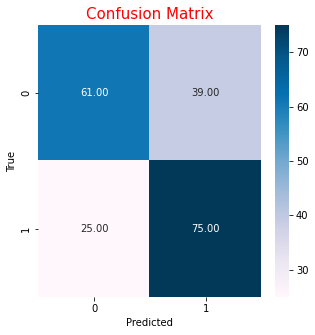

AUC: 0.7596999999999999


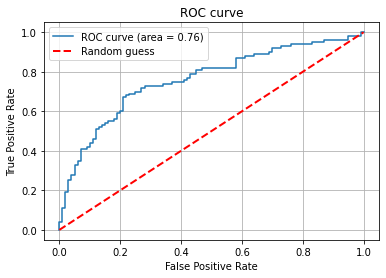

Step:  7
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          1   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          1   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          0   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          1   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          0   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          1   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          1   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          1   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          0   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          0   

     log odd score  
0        24.609095  
1         8.169703  
2       -64.739

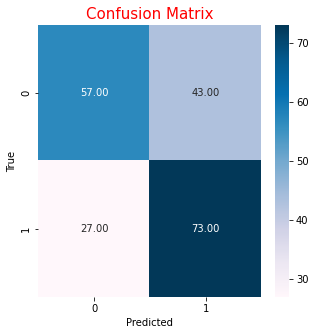

AUC: 0.7086


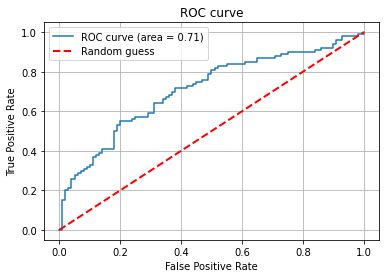

Step:  8
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          1   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          1   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          0   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          1   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          1   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          1   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          1   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          1   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          0   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          0   

     log odd score  
0        55.317561  
1        13.039321  
2      -146.066

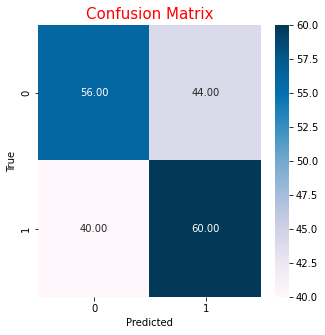

AUC: 0.6211000000000001


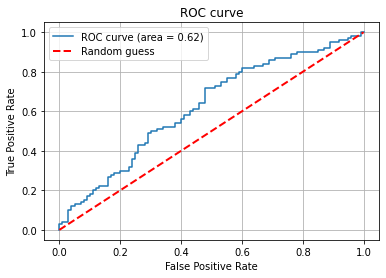

Step:  9
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          0   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          1   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          0   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          1   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          1   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          1   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          1   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          1   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          0   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          0   

     log odd score  
0        -5.896493  
1        30.204073  
2      -148.372

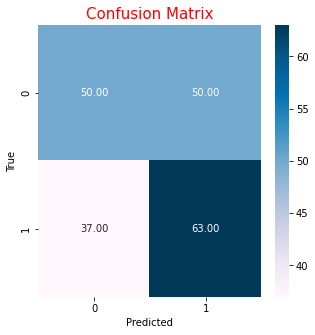

AUC: 0.5978999999999999


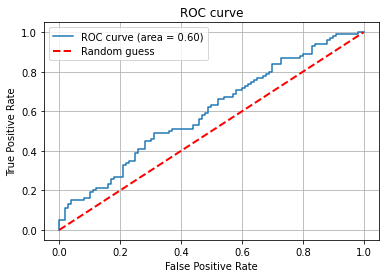

Step:  10
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          1   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          1   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          0   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          1   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          1   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          1   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          1   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          1   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          0   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          1   

     log odd score  
0        10.609082  
1        13.157177  
2        -8.54

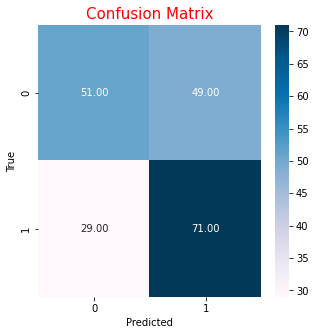

AUC: 0.652


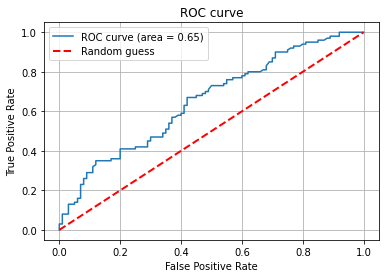

Step:  11
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          0   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          0   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          1   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          0   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          1   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          1   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          1   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          1   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          0   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          0   

     log odd score  
0         0.000000  
1        -4.615121  
2         9.23

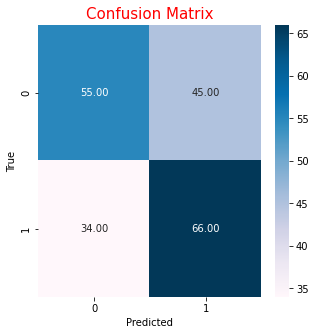

AUC: 0.6893


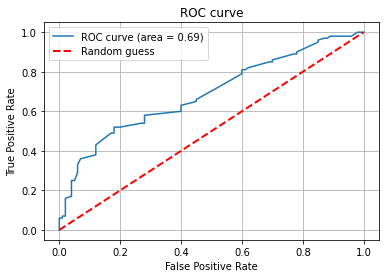

Step:  12
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          0   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          0   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          0   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          0   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          1   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          1   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          0   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          1   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          1   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          1   

     log odd score  
0         0.000000  
1       -18.460482  
2         0.00

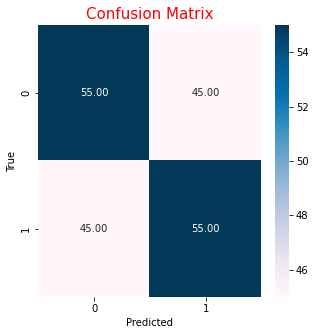

AUC: 0.6082


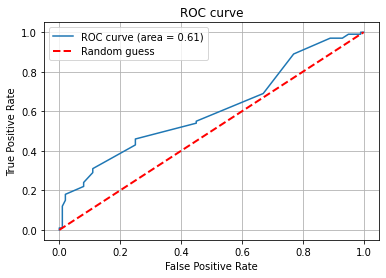

Step:  13
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          0   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          0   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          0   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          0   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          1   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          1   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          0   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          0   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          1   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          1   

     log odd score  
0         0.000000  
1       -13.845362  
2         0.00

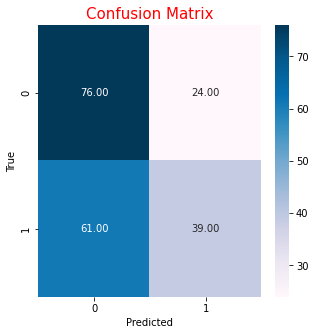

AUC: 0.58835


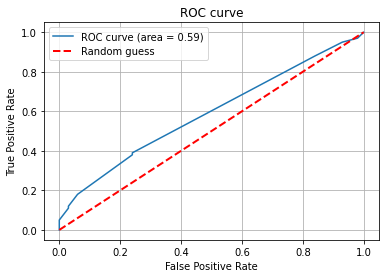

Step:  14
                                                   seq  Bound  predicted  \
0    CAGAATGGGGGTAGGTATCTTCACGGGTCGGGCCGTAGACGATAGG...      1          0   
1    GTTGTTGGCTTAAGATCTAGCAGCAGGCCGAAAAGAAGACCAGGCG...      1          0   
2    AGGTGATAAAGCATAACGTGGTTTCGTATCCTTACCAAGCCACCGA...      0          0   
3    GTTGTCTCAACTTCGAGTCTGACCTGTTTTAAGGCGAACTTCGTTT...      1          0   
4    GGCGACTTCCTCTCATCCAGCTTCTAGAACTAGCGATTAACGCATT...      1          0   
..                                                 ...    ...        ...   
195  CACGTTAATGTTACGCTAGTATTGCAATTGGCCAACGGTGTGTCCG...      1          0   
196  CTGCGGCCTAAACCTTACTACAAGCTTAGATAGGACAGGGGGTTGC...      0          0   
197  CCATGCAGCCCCAGGCTAAAGACTCGGATTGATCGGTAATGACAGG...      1          0   
198  GATCTCAGGTCTACAAGTGGCTCATCTGACGCTTAGCTCGACTCTT...      1          1   
199  ACGCTAACTACTGGTCGCCGACGGGGGTCCTTGGGCTGAAGTATTA...      0          0   

     log odd score  
0         0.000000  
1        -9.230241  
2         0.00

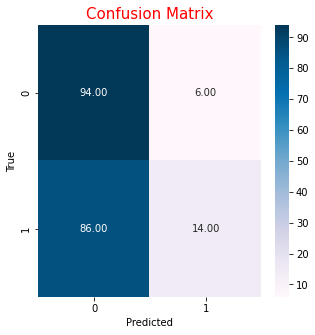

AUC: 0.5248


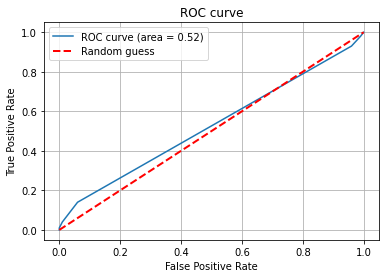

Step:  2
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          1   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          0   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          1   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          1   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          0   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          0   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          0   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          0   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          1   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          0   

     log odd score  
0         0.496188  
1        -0.377062  
2         0.341

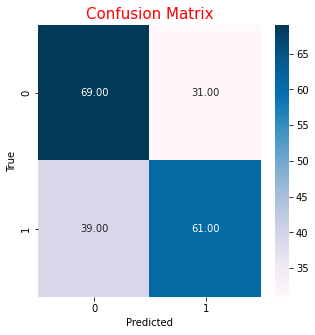

AUC: 0.6919999999999998


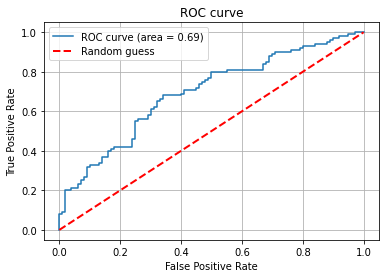

Step:  3
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          1   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          1   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          1   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          0   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          1   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          0   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          1   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          0   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          0   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          0   

     log odd score  
0         0.249042  
1         0.344335  
2         1.078

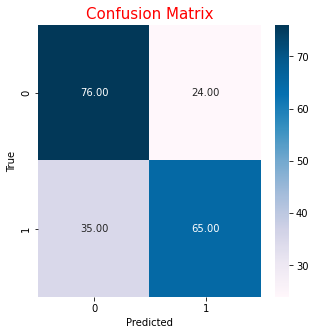

AUC: 0.7709999999999999


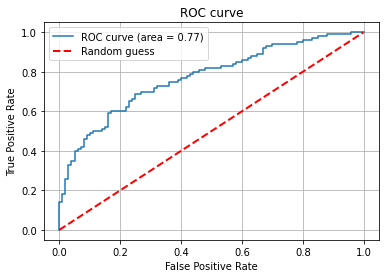

Step:  4
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          1   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          0   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          1   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          0   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          1   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          0   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          0   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          0   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          0   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          0   

     log odd score  
0         0.623731  
1        -0.237536  
2         0.143

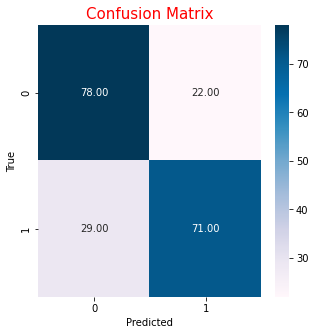

AUC: 0.8098


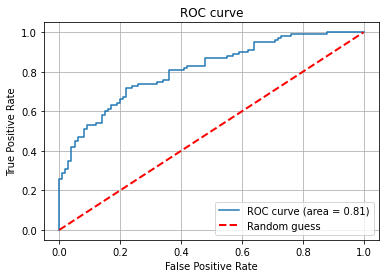

Step:  5
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          0   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          0   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          1   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          0   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          1   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          1   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          0   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          0   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          0   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          0   

     log odd score  
0        -2.940981  
1        -2.204336  
2         2.820

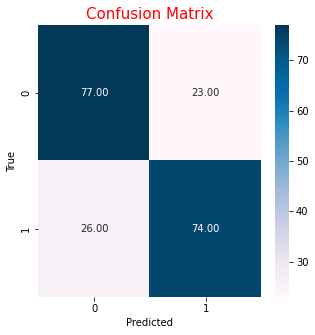

AUC: 0.7974


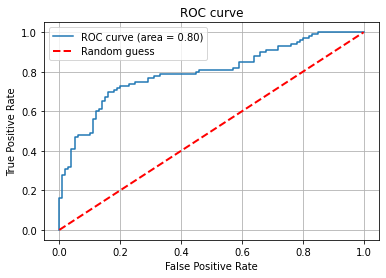

Step:  6
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          0   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          0   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          1   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          1   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          0   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          1   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          0   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          0   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          0   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          0   

     log odd score  
0       -13.496549  
1        -7.771932  
2        12.238

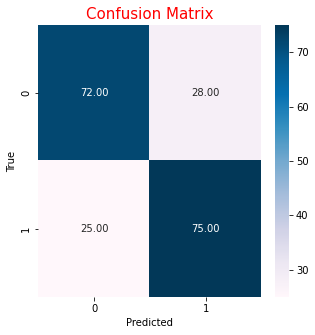

AUC: 0.7752


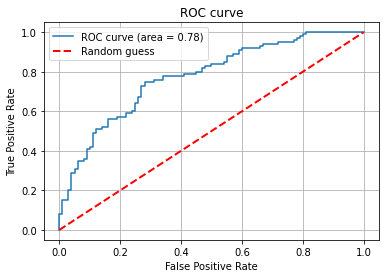

Step:  7
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          0   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          1   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          1   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          0   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          0   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          1   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          0   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          0   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          0   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          0   

     log odd score  
0       -20.956072  
1         6.079204  
2        22.446

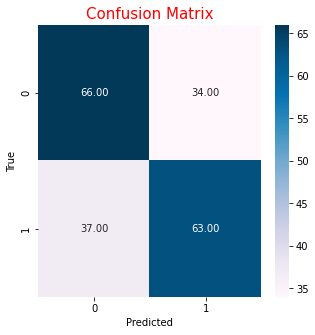

AUC: 0.6867


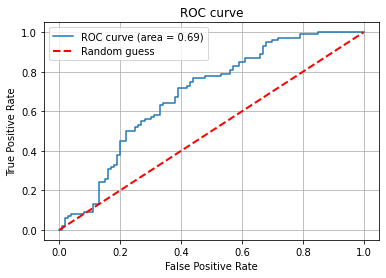

Step:  8
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          0   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          0   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          1   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          0   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          0   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          1   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          0   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          1   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          0   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          1   

     log odd score  
0       -72.641125  
1       -47.144359  
2       135.537

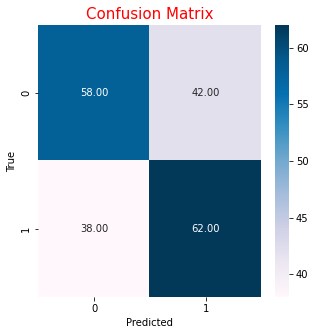

AUC: 0.6455


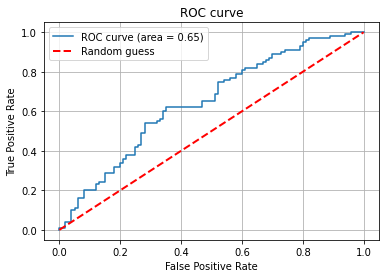

Step:  9
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          0   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          0   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          1   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          0   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          0   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          0   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          0   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          1   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          1   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          0   

     log odd score  
0      -115.983988  
1       -35.425169  
2        83.361

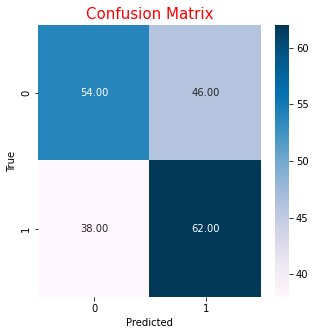

AUC: 0.6336999999999999


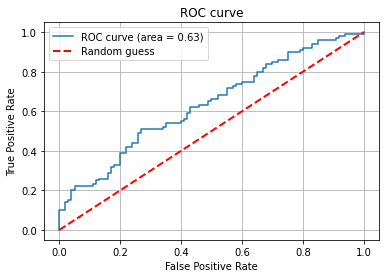

Step:  10
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          0   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          0   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          1   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          0   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          0   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          0   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          0   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          1   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          0   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          1   

     log odd score  
0       -78.457049  
1       -36.232780  
2        64.61

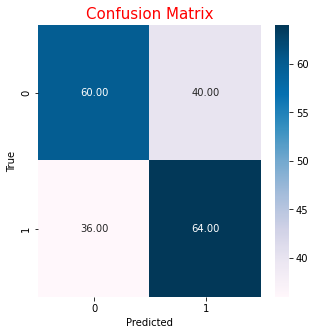

AUC: 0.6918


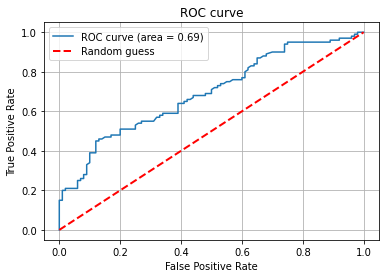

Step:  11
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          0   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          0   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          1   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          1   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          0   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          0   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          1   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          0   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          0   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          1   

     log odd score  
0       -32.305844  
1       -18.460482  
2        23.07

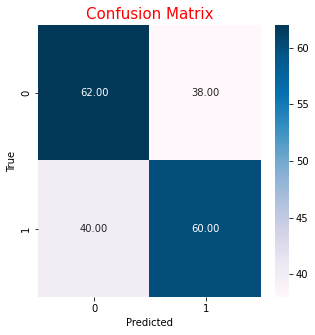

AUC: 0.6781


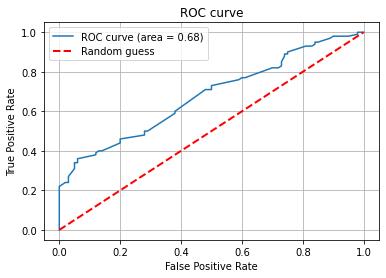

Step:  12
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          0   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          0   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          1   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          1   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          0   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          0   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          1   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          0   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          0   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          1   

     log odd score  
0        -4.615121  
1         0.000000  
2         4.61

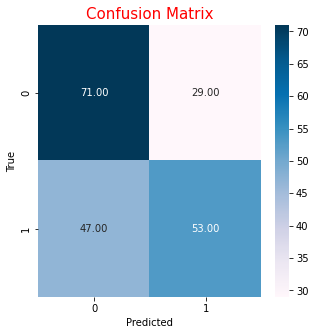

AUC: 0.6154000000000001


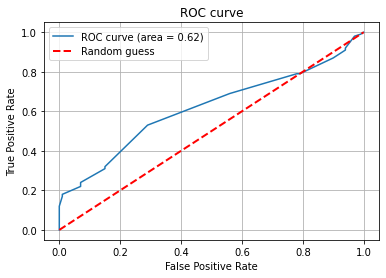

Step:  13
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          0   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          0   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          1   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          0   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          0   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          0   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          1   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          0   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          0   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          1   

     log odd score  
0         0.000000  
1         0.000000  
2         4.61

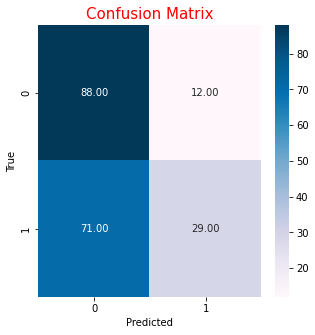

AUC: 0.5902499999999999


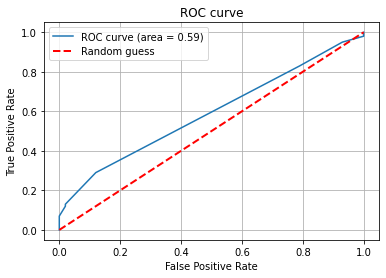

Step:  14
                                                   seq  Bound  predicted  \
0    TTGCGTTGTTTTAATTGATCCGACGGGGCTTTAAGTGCGAAGACAG...      0          0   
1    CATTACGAAGACTTCTCTTGGTTTTAAGTAGGGTCGCTAATTATAG...      0          0   
2    GAATTACGTCTTAATCGTTTTATTCGCTGAGTAAAATTAAGGACGG...      1          0   
3    AAGTAGCTAACCCTAAGGTTGATAGTTGCCGCAGGGTACGCACGTC...      1          0   
4    GCGTAGACGGGGGGGAGCTGGGAGCGTATGTCAGACAATCCAAGTA...      1          0   
..                                                 ...    ...        ...   
195  TATCCTTTCTGCCCAATATTTAACAGCGATTTTATAATATGTGGAG...      1          0   
196  AATCCCTCTTTTACGGTGGAAGCCTTGGTTCCGGCGTACGCACTGG...      0          1   
197  CACGTGGAGAATTCGTTTCCGCTGGGAGTCACGTATCTCTCTTATC...      0          0   
198  CCTTGAGTCGACGGACTTGGGTTGCCGGCTGGGCGATCGAGTTCAG...      0          0   
199  CCAAGCGACGGTAGCCGGTGGCGGGGGTTCCCTCCCCATACAAACT...      0          1   

     log odd score  
0         0.000000  
1         0.000000  
2         0.00

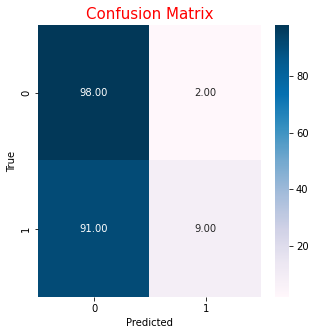

AUC: 0.5513


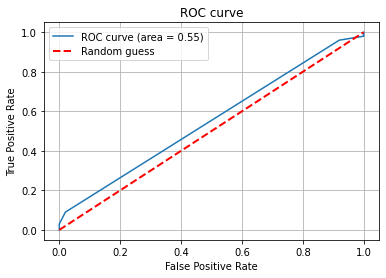

Step:  2
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          1   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          1   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          0   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          1   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          1   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          0   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          1   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          1   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          0   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          1   

     log odd score  
0         4.370669  
1         1.005086  
2        -0.148

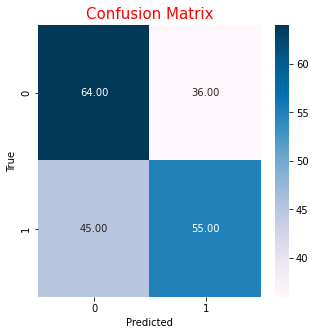

AUC: 0.6532


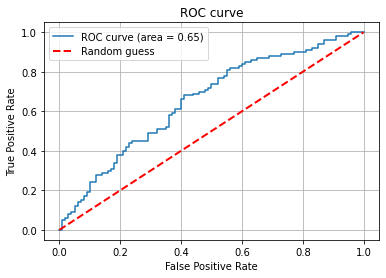

Step:  3
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          1   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          1   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          0   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          1   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          1   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          0   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          1   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          1   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          0   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          1   

     log odd score  
0         5.835927  
1         2.401093  
2        -0.688

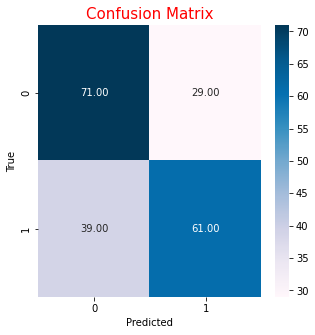

AUC: 0.7348999999999999


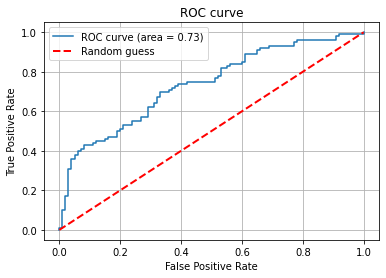

Step:  4
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          1   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          1   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          1   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          1   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          1   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          0   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          1   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          0   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          0   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          1   

     log odd score  
0        11.013056  
1         3.902348  
2         0.380

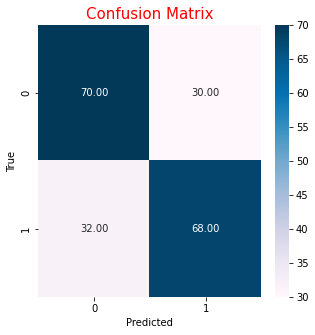

AUC: 0.7691


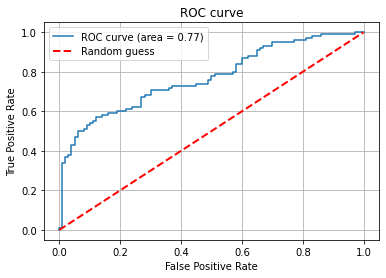

Step:  5
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          1   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          1   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          1   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          1   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          1   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          0   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          1   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          0   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          0   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          1   

     log odd score  
0        16.197218  
1         8.686378  
2         2.111

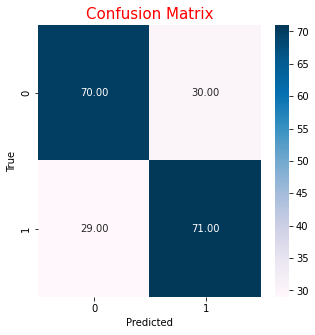

AUC: 0.7879


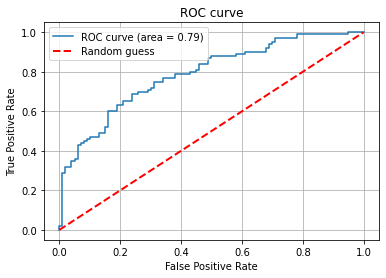

Step:  6
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          1   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          1   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          1   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          1   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          1   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          0   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          1   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          0   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          1   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          1   

     log odd score  
0        23.756958  
1         8.967208  
2         2.032

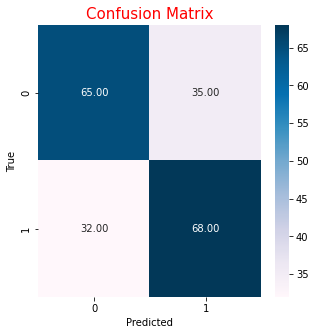

AUC: 0.7252999999999998


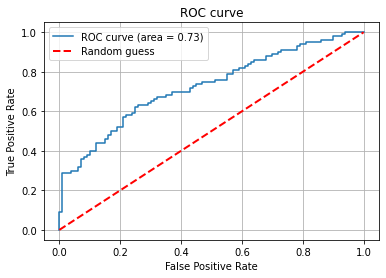

Step:  7
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          0   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          1   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          1   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          1   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          0   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          1   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          1   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          0   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          1   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          1   

     log odd score  
0        -2.384255  
1         6.810455  
2        13.491

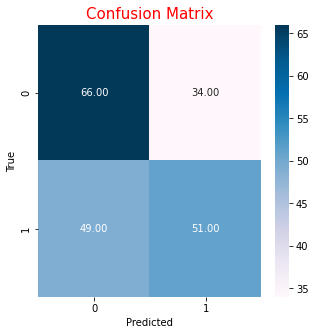

AUC: 0.6382


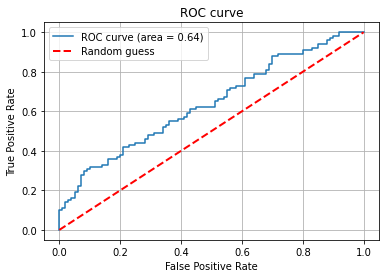

Step:  8
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          1   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          0   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          0   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          1   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          0   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          0   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          1   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          0   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          0   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          1   

     log odd score  
0       114.230139  
1       -12.797463  
2        -4.490

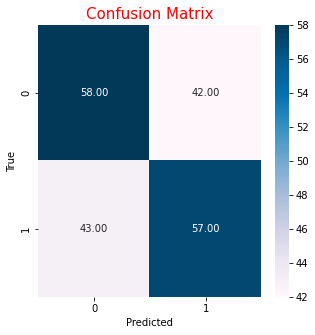

AUC: 0.6044


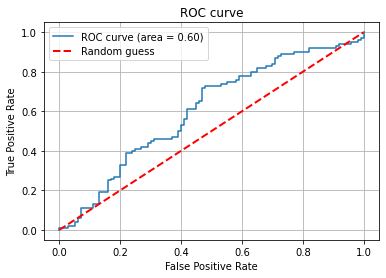

Step:  9
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          1   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          0   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          1   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          1   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          0   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          1   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          1   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          0   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          0   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          1   

     log odd score  
0       113.720272  
1       -25.555201  
2         4.936

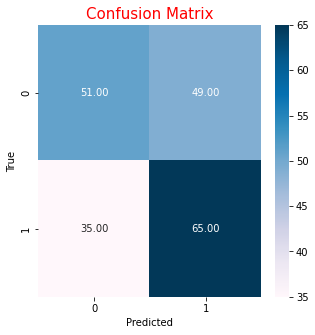

AUC: 0.631


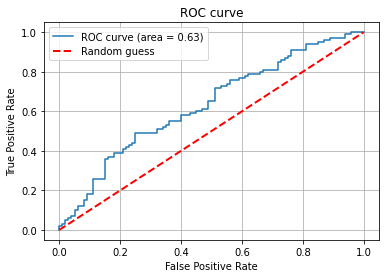

Step:  10
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          1   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          1   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          1   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          1   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          1   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          1   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          1   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          0   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          0   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          1   

     log odd score  
0        47.931379  
1        28.411364  
2         5.99

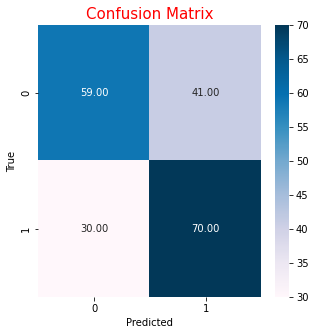

AUC: 0.6803000000000001


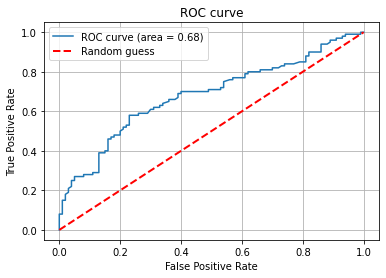

Step:  11
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          1   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          1   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          0   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          1   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          1   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          1   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          1   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          1   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          0   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          1   

     log odd score  
0        27.690723  
1        37.446202  
2        -4.61

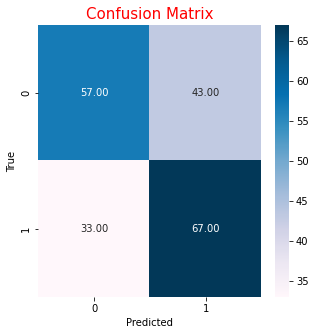

AUC: 0.66455


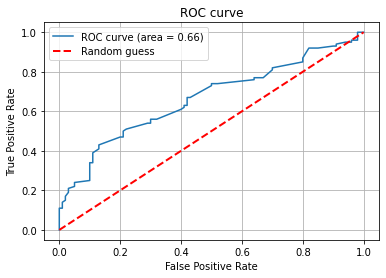

Step:  12
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          1   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          1   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          0   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          0   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          0   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          0   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          1   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          1   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          0   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          1   

     log odd score  
0         4.615121  
1        14.533546  
2        -9.23

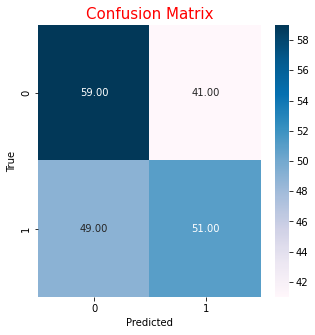

AUC: 0.5911000000000001


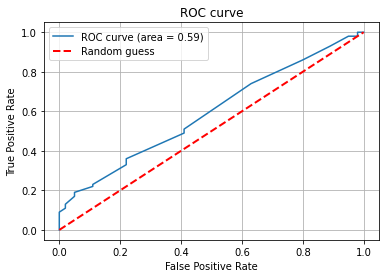

Step:  13
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          1   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          1   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          0   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          0   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          1   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          0   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          1   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          0   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          0   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          0   

     log odd score  
0         4.615121  
1         4.615121  
2        -4.61

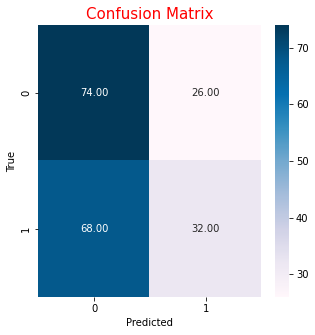

AUC: 0.5331


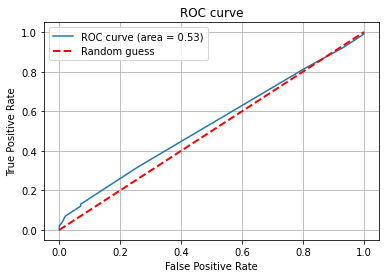

Step:  14
                                                   seq  Bound  predicted  \
0    CCTAAACTAACGGCCATAGACCCCCCCGAAAGAACTCCCTGGCCAG...      0          0   
1    GTCCACTATGGGTGTACTCGCCTTGGATGGCCCACTACGTAAATAC...      1          0   
2    AGGAAGACATAAGCGGCAGCACCGTGAACTGGGCTGACCGCGGTGA...      0          0   
3    GAGCCATTTTAGGTGCTCAGTACGGTACTTGCCGACAGGGGTGCCG...      1          0   
4    AACTGGCGATAACCTGCGTAGATGACAAGGTGCCTCCTCAAAGCGC...      1          0   
..                                                 ...    ...        ...   
195  CAAAATAGTGATAAATTGACTTCTATAGACTAGTTGATGAACCCCC...      0          0   
196  TACCTACCGGGAGGTTGATACCTCTCAGGGGCACTGTACTGTCTTA...      1          0   
197  CAGGAACACATTAATCTGGGCGTTACAACTAGACCAACTTGCAGTC...      0          0   
198  TTTCTTTCGTTGAATAGACGGCTCCCAATAGTTAACTCTTTCGATC...      1          0   
199  GACATCTCGGGACATAAAATGCTCGGGGTCGTCTGCGGCCCACTTA...      1          0   

     log odd score  
0              0.0  
1              0.0  
2             

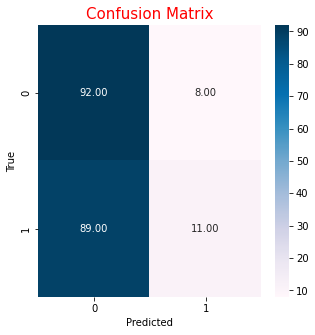

AUC: 0.5043500000000001


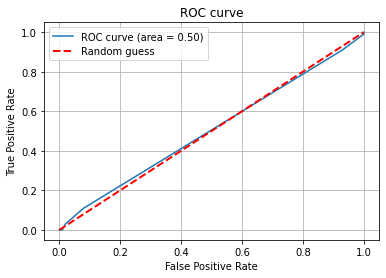

Step:  2
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          1   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          1   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          0   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          0   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          1   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          1   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          1   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          0   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          1   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          1   

     log odd score  
0         0.043716  
1         0.773040  
2        -1.563

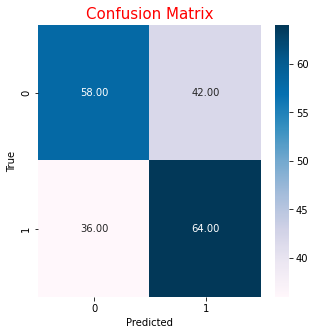

AUC: 0.6649


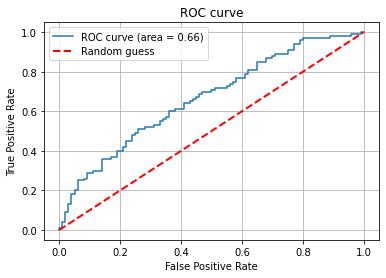

Step:  3
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          1   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          1   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          0   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          0   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          0   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          1   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          1   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          0   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          1   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          1   

     log odd score  
0         0.561523  
1         0.512776  
2        -2.991

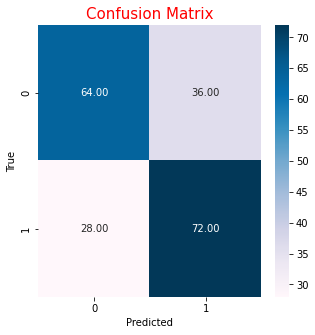

AUC: 0.7310000000000001


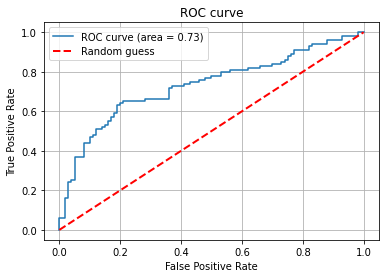

Step:  4
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          1   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          1   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          0   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          0   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          0   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          1   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          1   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          0   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          0   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          1   

     log odd score  
0         3.242027  
1         2.145194  
2        -4.687

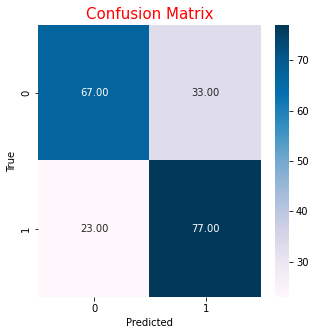

AUC: 0.7985


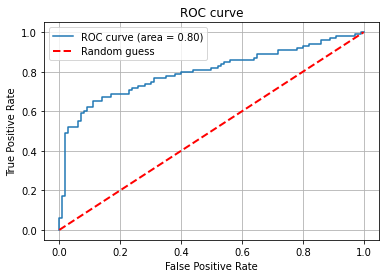

Step:  5
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          1   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          1   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          0   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          1   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          0   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          1   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          1   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          0   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          0   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          1   

     log odd score  
0         4.860744  
1         2.761348  
2        -8.892

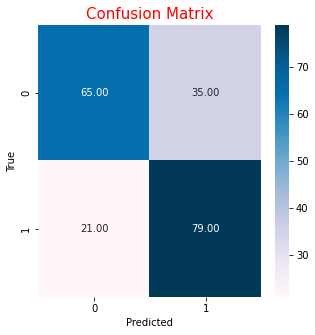

AUC: 0.7919


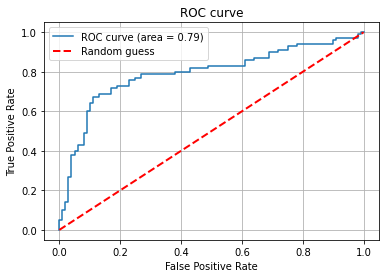

Step:  6
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          1   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          0   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          0   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          1   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          1   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          1   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          1   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          0   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          0   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          1   

     log odd score  
0         5.802938  
1        -5.290306  
2        -4.498

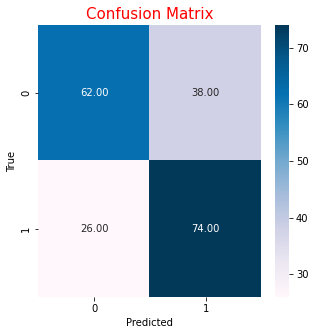

AUC: 0.7598


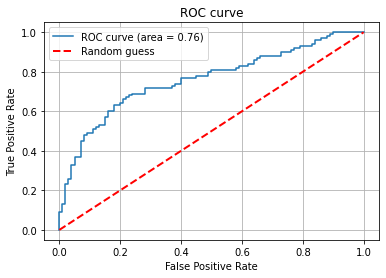

Step:  7
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          1   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          0   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          1   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          1   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          1   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          1   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          0   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          0   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          0   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          0   

     log odd score  
0        14.588737  
1       -47.301964  
2        35.490

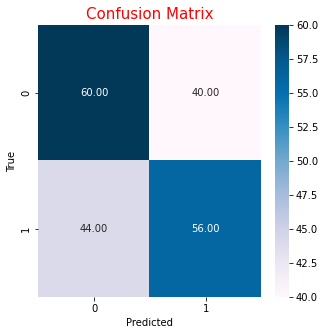

AUC: 0.6132


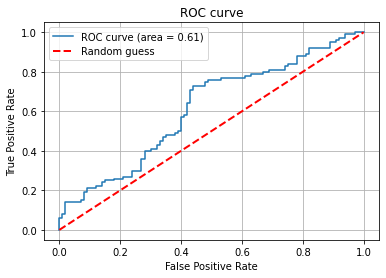

Step:  8
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          1   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          0   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          0   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          1   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          1   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          1   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          1   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          0   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          0   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          1   

     log odd score  
0       135.140089  
1      -163.644237  
2       -94.890

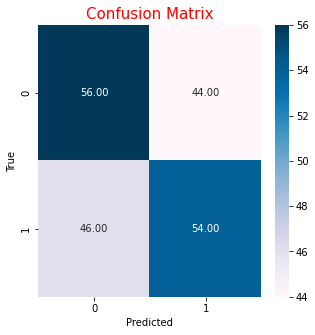

AUC: 0.5710999999999999


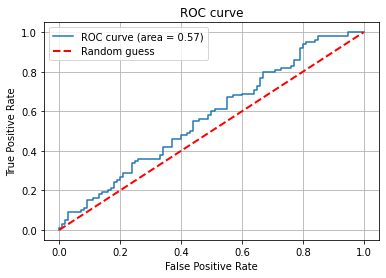

Step:  9
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          1   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          0   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          0   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          1   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          1   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          1   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          1   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          0   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          0   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          1   

     log odd score  
0        87.361399  
1       -66.474252  
2       -96.027

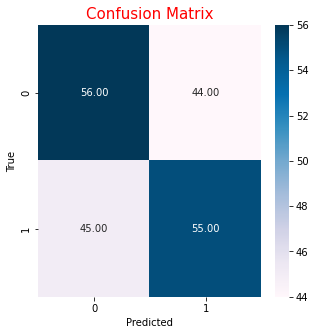

AUC: 0.5568


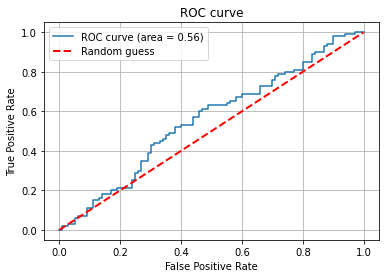

Step:  10
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          1   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          1   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          0   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          0   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          0   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          0   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          1   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          1   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          0   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          1   

     log odd score  
0        43.635783  
1        11.442646  
2       -87.68

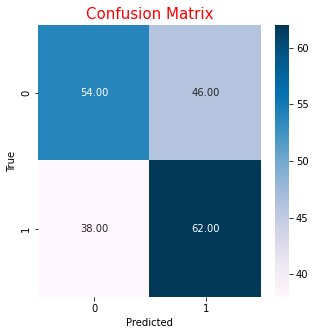

AUC: 0.6085499999999999


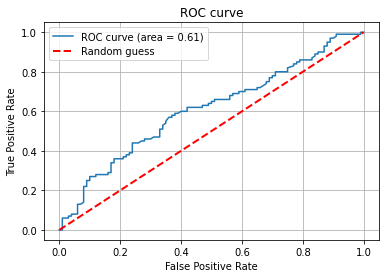

Step:  11
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          1   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          1   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          0   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          0   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          0   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          0   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          1   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          0   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          0   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          1   

     log odd score  
0        26.165197  
1        19.552472  
2       -36.92

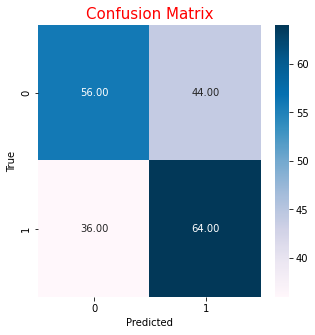

AUC: 0.621


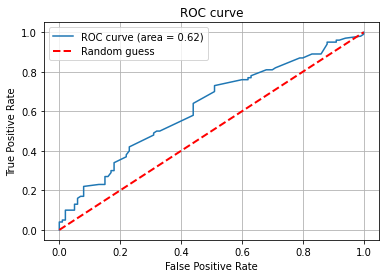

Step:  12
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          1   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          1   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          0   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          0   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          0   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          0   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          1   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          0   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          0   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          1   

     log odd score  
0        20.240656  
1         9.230241  
2       -13.84

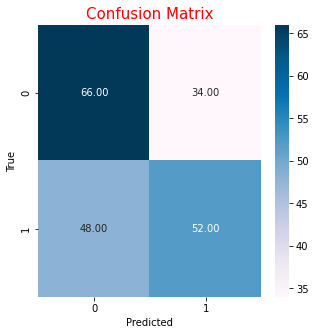

AUC: 0.60315


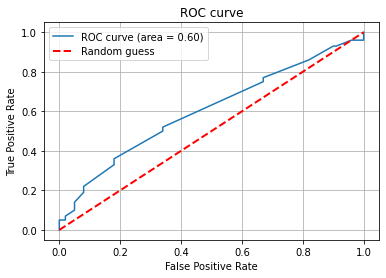

Step:  13
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          1   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          0   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          0   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          0   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          0   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          0   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          1   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          0   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          0   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          1   

     log odd score  
0         4.615121  
1         0.000000  
2         0.00

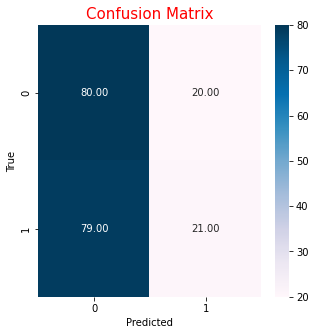

AUC: 0.50135


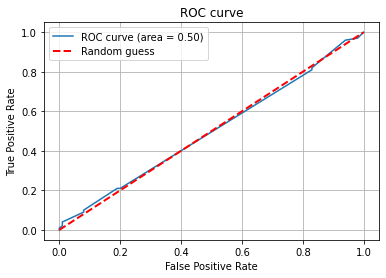

Step:  14
                                                   seq  Bound  predicted  \
0    AATTCGGCGCGAGCGTATGAGCCGTTAGCTTTGCTTGTAACATTAC...      1          0   
1    CGCATAGCTGAGGTCTGACATCAAGGTGTAGGACGGGATGAAGCCA...      1          0   
2    CCACTAAATATGCGGACTGCATTCGTTAACGTCATGGCATTTCGAA...      0          0   
3    GCCTGATGACCCGCATTGGCCAGCGTCGACGCCGCGGTCCGGGCGG...      0          0   
4    ACCGCGCCTTAGCGTGGCTTGCCAACCTGTAAGAGGCCCCTCTCGT...      0          0   
..                                                 ...    ...        ...   
195  GGTTGTACCCCCGAGGTTTCTGCTCGTGAGGTATTGGAGGCCACCA...      1          0   
196  CGCTGTCGTATGGGGCTAAAGGTACGCATCACTGGGTTCGTCCCTA...      1          0   
197  ACAAGGTCTAACCCCAGGTAGGTCCGGTCTGCTCTGTTCTTATGAC...      0          0   
198  GACTCGTTTGAGAAATAGCAAATAGGTCACTCTCTCACTCCTAGAC...      0          0   
199  TGTGTTGACCTCAGGCCTGAAGTTTTTTTATATCCTTGGAAATTCA...      1          1   

     log odd score  
0         0.000000  
1         0.000000  
2         0.00

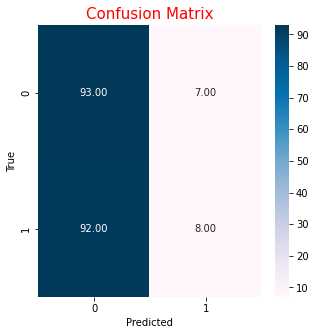

AUC: 0.5057


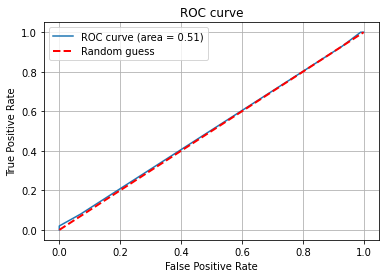

Step:  2
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          1   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          0   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          0   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          1   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          1   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          0   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          1   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          0   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          1   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0         0.431004  
1        -1.205092  
2        -0.047

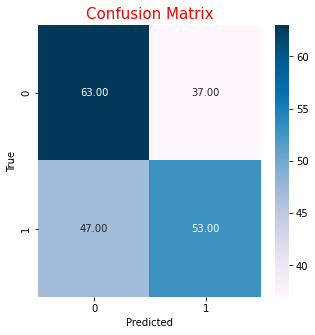

AUC: 0.6288


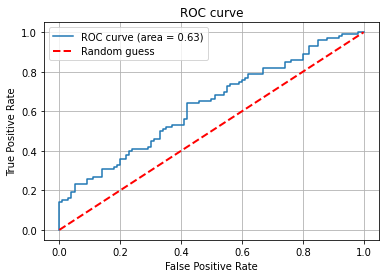

Step:  3
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          1   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          0   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          0   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          1   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          1   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          0   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          1   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          0   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          1   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0         0.885685  
1        -1.611832  
2        -0.041

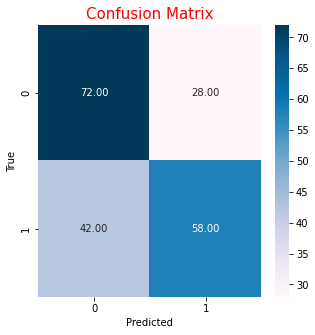

AUC: 0.7108


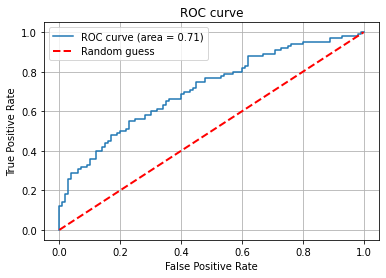

Step:  4
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          1   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          0   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          1   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          1   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          1   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          0   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          1   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          0   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          1   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0         2.238044  
1        -2.983639  
2         2.119

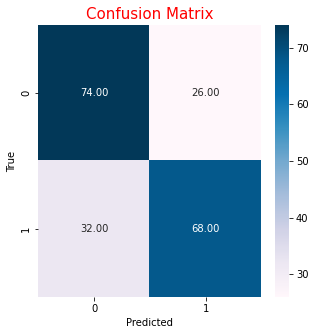

AUC: 0.7533000000000001


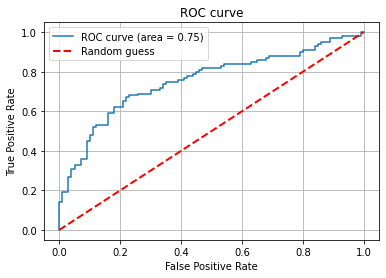

Step:  5
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          1   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          0   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          1   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          0   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          1   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          1   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          1   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          0   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          1   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0         0.143282  
1        -2.728757  
2         6.067

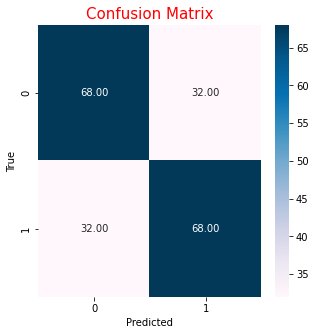

AUC: 0.7599


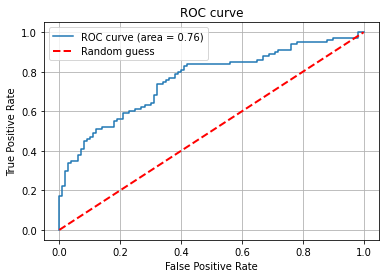

Step:  6
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          0   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          0   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          1   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          0   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          1   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          1   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          1   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          0   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          1   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0        -9.586945  
1        -2.422001  
2         6.400

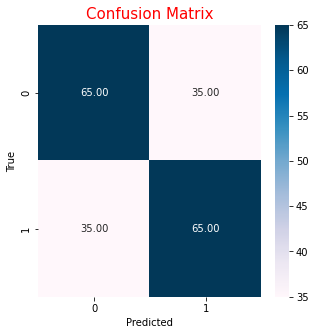

AUC: 0.7150000000000001


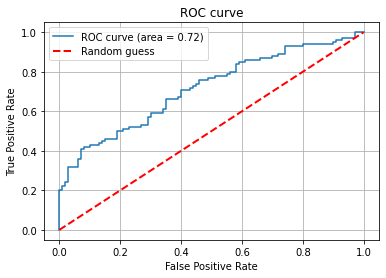

Step:  7
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          0   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          0   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          1   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          0   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          1   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          0   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          0   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          0   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          1   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0       -43.776199  
1       -18.140954  
2        24.644

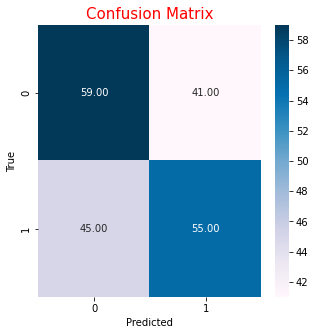

AUC: 0.6106


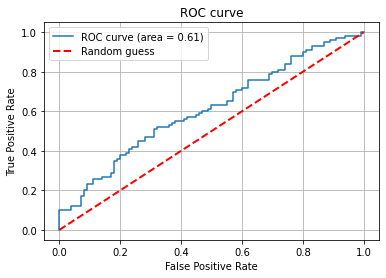

Step:  8
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          0   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          0   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          1   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          0   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          1   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          0   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          1   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          1   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          0   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0      -188.983047  
1       -58.017831  
2        18.715

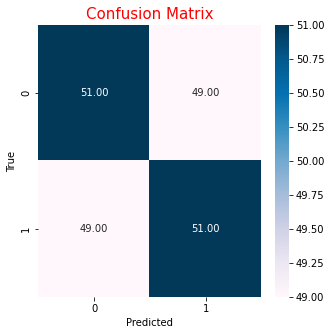

AUC: 0.5381


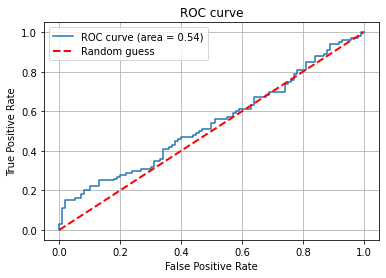

Step:  9
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          0   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          1   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          1   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          0   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          0   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          0   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          1   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          1   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          1   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0      -104.487559  
1        16.598099  
2        10.375

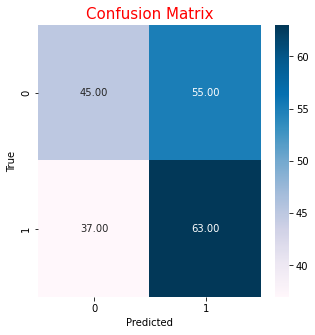

AUC: 0.5867


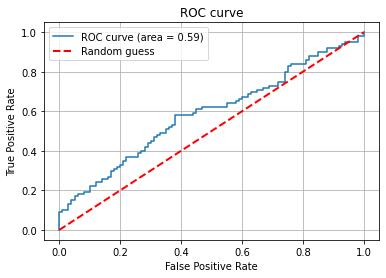

Step:  10
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          0   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          1   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          1   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          1   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          0   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          0   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          1   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          0   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          1   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0      -120.681318  
1        28.378907  
2         4.33

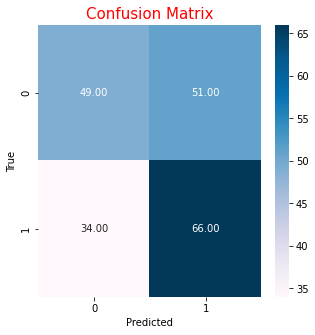

AUC: 0.61645


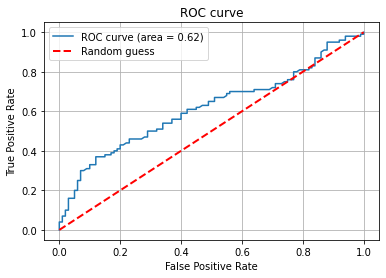

Step:  11
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          0   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          1   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          0   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          1   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          0   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          1   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          1   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          0   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          1   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0       -73.841928  
1         4.615121  
2        -5.30

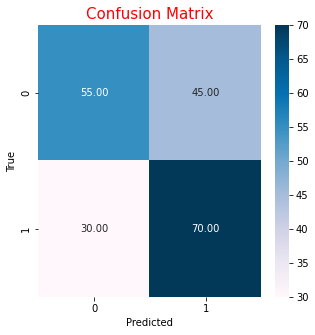

AUC: 0.6588499999999999


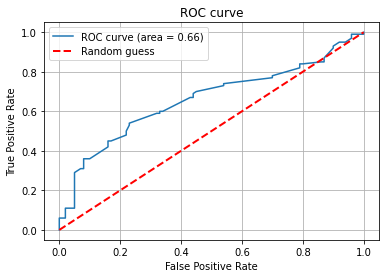

Step:  12
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          0   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          1   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          1   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          1   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          0   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          1   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          1   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          0   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          0   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0       -32.305844  
1         4.615121  
2         4.61

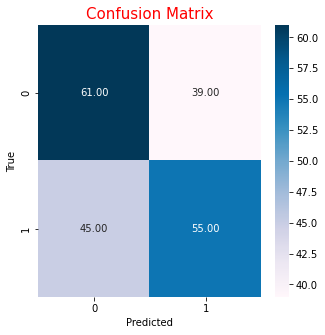

AUC: 0.5810500000000001


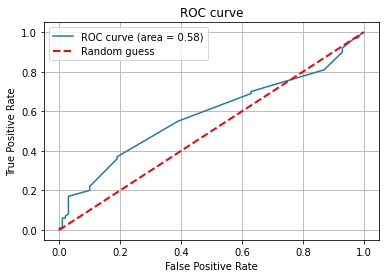

Step:  13
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          0   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          0   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          0   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          1   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          0   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          1   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          1   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          0   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          0   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0        -9.230241  
1         0.000000  
2         0.00

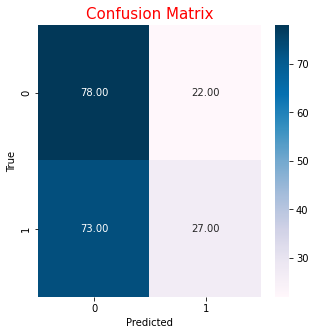

AUC: 0.4908


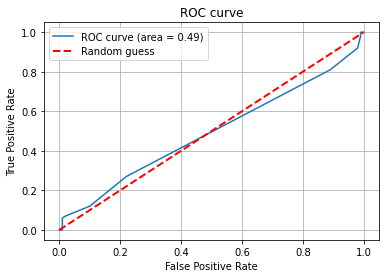

Step:  14
                                                   seq  Bound  predicted  \
0    GGAACTCCGCATACCGTACTCGAACACGGCCGAGGACCTGGACGTG...      1          0   
1    TAATATACCTAACGCGGTCAGTGACCACTTGATTTAAGCCCTGGCA...      1          0   
2    AAACGAGATGTCAAAATGAGGCGTTACAGAACTATGATCCTGTAGG...      1          0   
3    AGAGCCGCGTTTCGATACCTTCCAGTGCGATAAACTCCAGGATCTT...      1          0   
4    TCTACGCAGACCATCTGAATCAGGGTCCTTCCTTAATATTAAGCAT...      1          0   
..                                                 ...    ...        ...   
195  TTGCAGAGTACGGCATTTGACCCTTCATCCCAGAAAATAGTGCTGG...      1          0   
196  GCATTGGGTGAGTATACCGGCCTCAGGCCCAGAGTCCTTACGGACG...      1          0   
197  TTTCATGATCTCGACTCAATGCCGTCGAAAAGTTGCACTACCTTCT...      1          0   
198  GGTAGCCTTTGTGCCGGAGTCACAGGACTAATAGCATCAGCTCTTT...      1          0   
199  CGGTAAACAAGTACGTAGGCGATTTCCAGCCGCCTACTCTCCATTT...      0          0   

     log odd score  
0         0.000000  
1         0.000000  
2         0.00

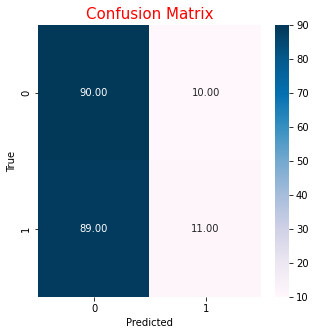

AUC: 0.4835500000000001


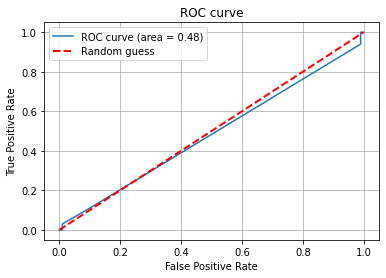

Step:  2
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          1   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          0   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          1   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          1   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          1   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          0   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          1   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          1   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          1   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          0   

     log odd score  
0         1.014164  
1        -1.295266  
2         0.464

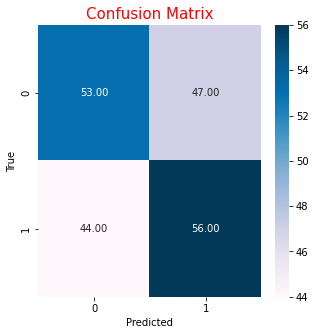

AUC: 0.6064


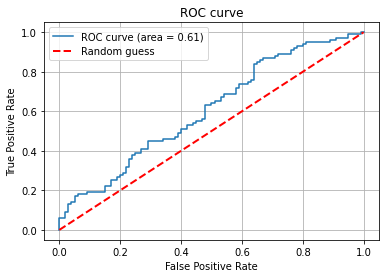

Step:  3
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          1   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          0   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          1   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          0   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          1   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          1   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          0   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          1   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          1   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          0   

     log odd score  
0         0.885627  
1        -0.606036  
2         0.604

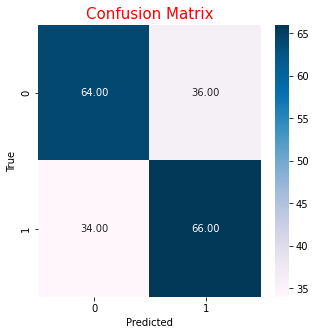

AUC: 0.7006


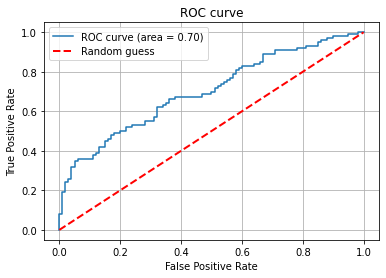

Step:  4
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          0   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          1   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          0   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          0   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          1   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          1   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          0   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          1   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          1   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          0   

     log odd score  
0        -0.049566  
1         1.984374  
2        -0.370

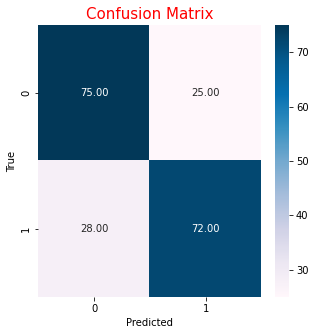

AUC: 0.7930999999999999


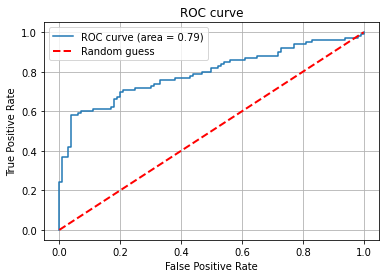

Step:  5
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          0   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          1   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          0   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          1   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          1   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          1   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          0   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          1   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          1   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          0   

     log odd score  
0        -1.382838  
1         1.931367  
2        -1.799

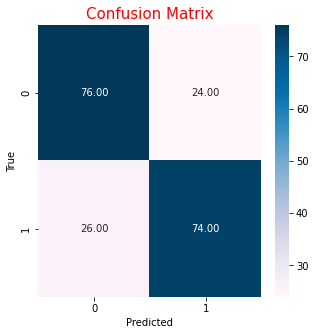

AUC: 0.8094


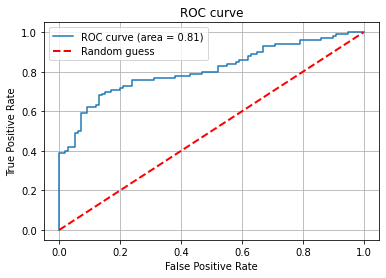

Step:  6
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          0   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          1   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          0   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          1   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          1   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          1   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          0   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          1   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          1   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          0   

     log odd score  
0        -6.933976  
1         3.215637  
2        -4.458

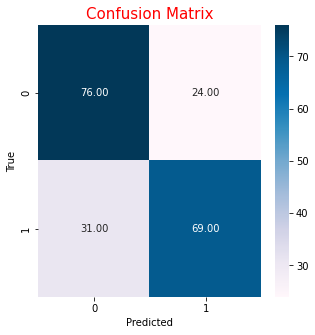

AUC: 0.7832999999999999


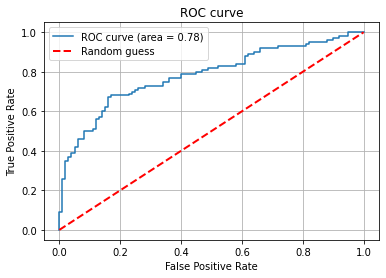

Step:  7
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          1   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          0   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          0   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          1   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          0   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          1   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          0   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          1   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          0   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          0   

     log odd score  
0         1.783949  
1       -16.627667  
2        -0.241

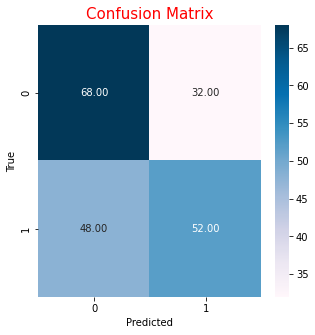

AUC: 0.6232000000000001


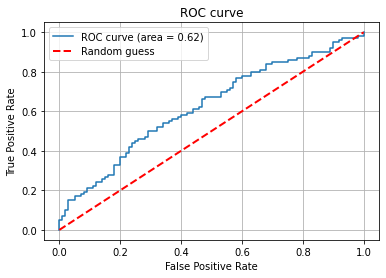

Step:  8
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          1   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          0   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          0   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          1   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          0   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          1   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          0   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          1   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          0   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          1   

     log odd score  
0        72.055556  
1       -30.408002  
2       -32.543

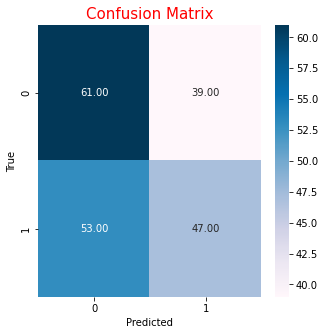

AUC: 0.5716


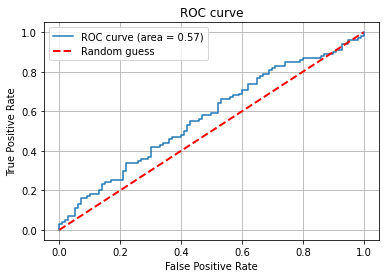

Step:  9
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          1   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          0   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          0   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          1   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          1   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          1   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          0   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          1   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          1   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          1   

     log odd score  
0        78.092933  
1       -35.603858  
2       -51.858

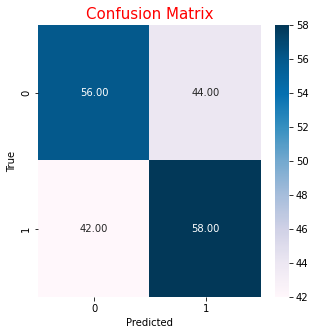

AUC: 0.58725


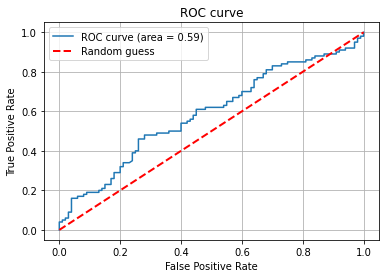

Step:  10
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          1   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          1   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          0   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          0   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          1   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          1   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          0   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          1   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          1   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          1   

     log odd score  
0        36.920964  
1         5.991489  
2       -32.30

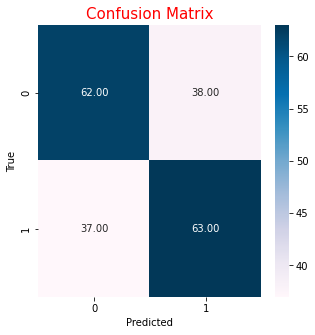

AUC: 0.6605000000000001


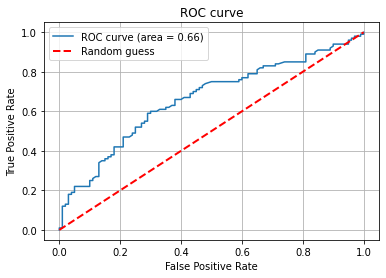

Step:  11
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          1   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          0   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          0   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          0   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          1   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          1   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          0   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          1   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          1   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          1   

     log odd score  
0        23.075603  
1        -9.230241  
2         0.00

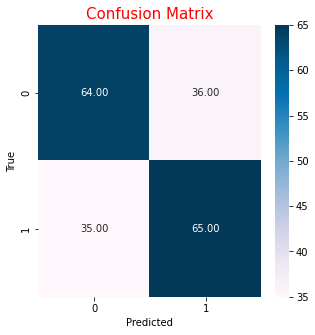

AUC: 0.65225


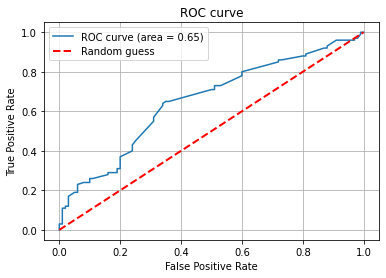

Step:  12
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          1   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          0   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          0   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          0   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          1   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          1   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          0   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          0   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          0   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          1   

     log odd score  
0         4.615121  
1        -9.230241  
2         0.00

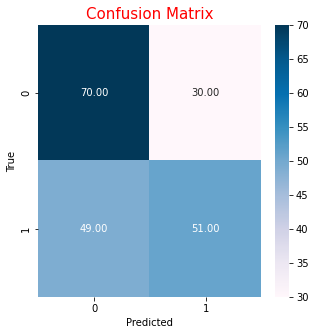

AUC: 0.6155999999999999


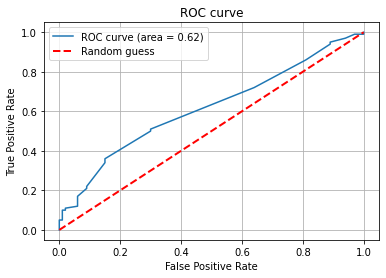

Step:  13
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          0   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          0   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          0   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          0   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          1   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          1   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          0   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          0   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          0   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          1   

     log odd score  
0         0.000000  
1         0.000000  
2         0.00

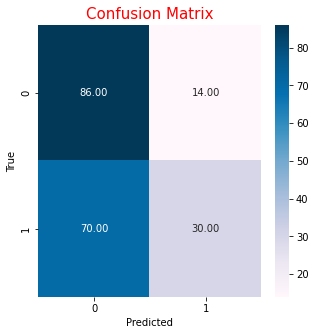

AUC: 0.5926499999999999


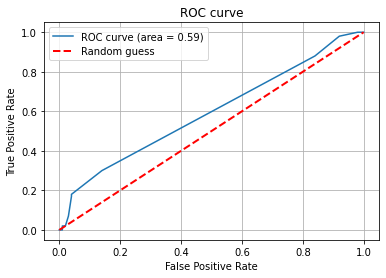

Step:  14
                                                   seq  Bound  predicted  \
0    ATACGGCCTGAGCCCACGGCATCACAGTCAATAGATCTCCGGGAGC...      0          0   
1    CATGCGGAGTCCGGGAGTCCTGCCCCGGTTCGTGGCTTGTCGGGCG...      1          0   
2    CATCGTCATAACTTGTCCGACGAGACACAGTTTTTAAAATACCAGT...      0          0   
3    ACCCCTGCATGGGGAGGGAACCATAAATGCATCGCATGACTCCCCC...      0          0   
4    CCACGTGCGGAGGACCATGCTAGTTAAATGACTCAGGCCGAAGTTG...      1          0   
..                                                 ...    ...        ...   
195  GGTTAACGTCCCGAAATGTACGAGAGCCTATATTTAGACGGATCTT...      1          1   
196  CTCTTGTATTCCCGCAGCTCGCCAGGACGCGGACTGGCGGAATATC...      0          0   
197  TCACTTCCCAACGGTGAGCTCCATATGATTCGCATGAGAGTGCGAA...      1          0   
198  CGGCGTTCGGCTGTGCTTAAGCAGGTCATTGGCCCTCCTGATGACT...      1          0   
199  TTTTAGTGAATATTCGTCGTGGCGTTTAGGTGCGTTGTATAGCTAC...      1          0   

     log odd score  
0         0.000000  
1         0.000000  
2         0.00

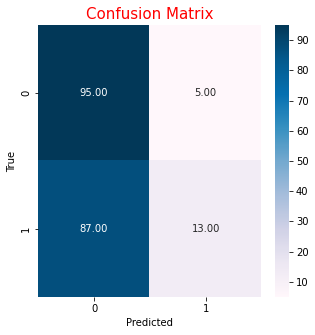

AUC: 0.5608499999999998


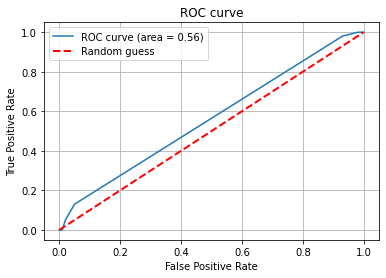

Step:  2
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          1   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          0   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          1   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          0   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          0   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          0   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          1   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          1   

     log odd score  
0         1.401832  
1        -0.523583  
2         0.986

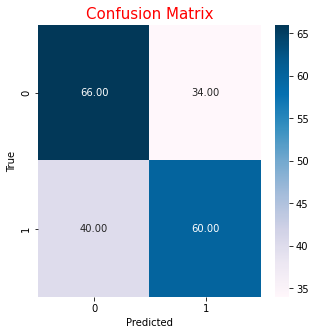

AUC: 0.6920999999999999


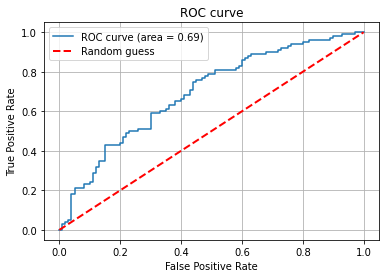

Step:  3
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          1   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          1   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          1   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          0   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          0   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          0   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          1   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          1   

     log odd score  
0         2.857796  
1         0.612622  
2         2.205

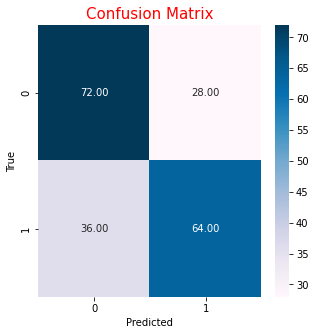

AUC: 0.7456


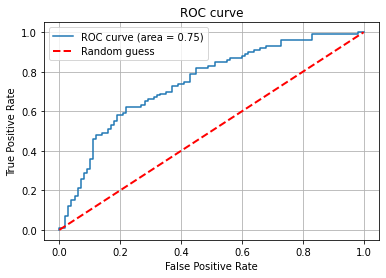

Step:  4
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          1   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          1   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          1   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          0   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          0   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          0   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          1   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          1   

     log odd score  
0         4.964536  
1         2.201274  
2         3.386

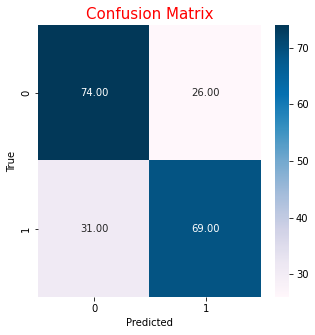

AUC: 0.7913000000000001


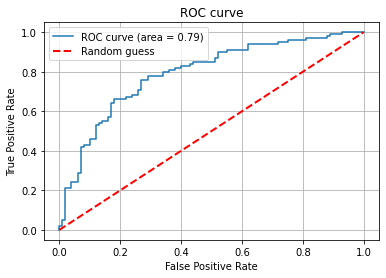

Step:  5
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          1   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          1   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          1   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          0   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          1   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          1   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          1   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          1   

     log odd score  
0         7.139125  
1         5.452657  
2         4.204

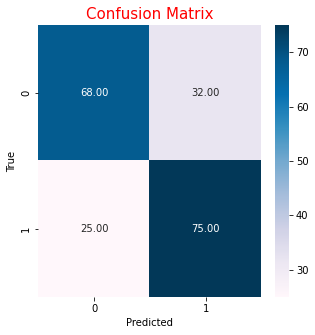

AUC: 0.8006


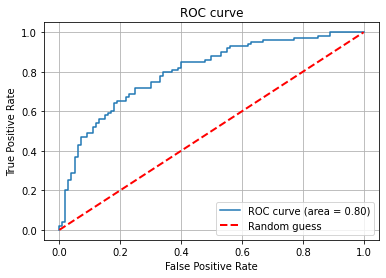

Step:  6
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          1   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          1   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          0   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          0   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          1   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          1   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          0   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          1   

     log odd score  
0         8.752718  
1         2.100243  
2        -0.892

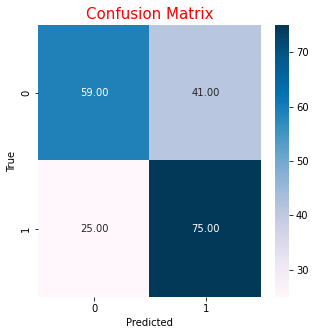

AUC: 0.7274999999999999


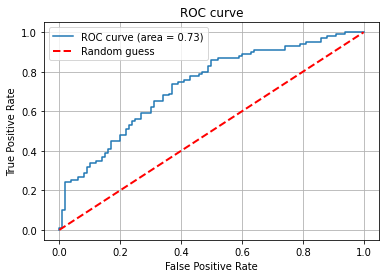

Step:  7
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          1   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          1   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          0   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          0   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          1   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          0   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          0   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          1   

     log odd score  
0        34.318727  
1         0.824471  
2        -7.802

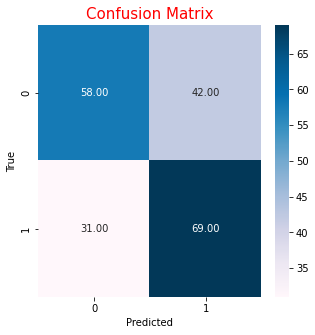

AUC: 0.645


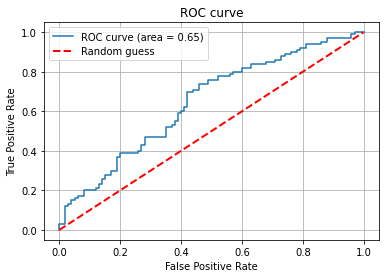

Step:  8
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          1   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          0   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          0   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          1   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          0   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          0   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          0   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          1   

     log odd score  
0        67.625095  
1       -79.722067  
2       -33.212

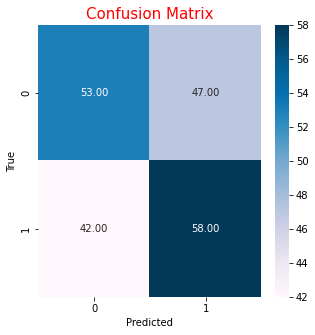

AUC: 0.5963000000000002


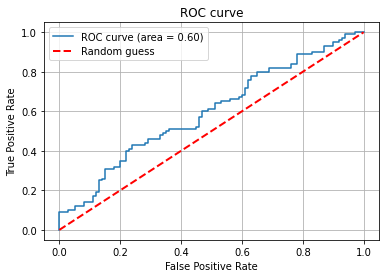

Step:  9
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          1   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          1   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          0   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          0   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          1   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          0   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          0   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          1   

     log odd score  
0        71.445000  
1        37.349219  
2       -67.850

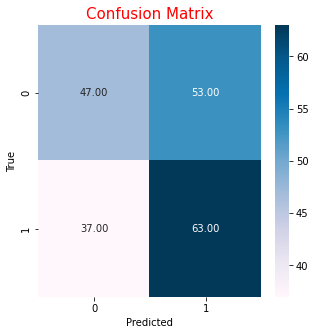

AUC: 0.5746


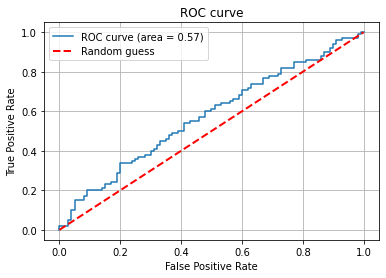

Step:  10
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          1   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          1   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          0   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          0   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          1   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          0   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          1   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          1   

     log odd score  
0        70.887556  
1        77.223588  
2       -13.84

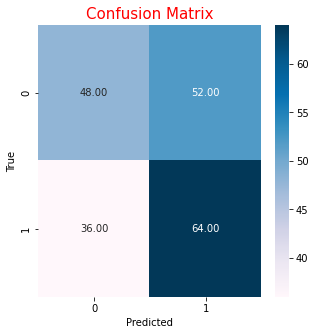

AUC: 0.5966


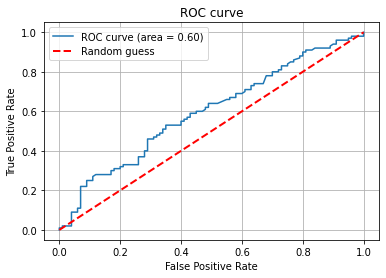

Step:  11
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          1   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          1   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          1   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          0   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          1   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          1   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          1   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          1   

     log odd score  
0        32.994028  
1        50.766326  
2        13.84

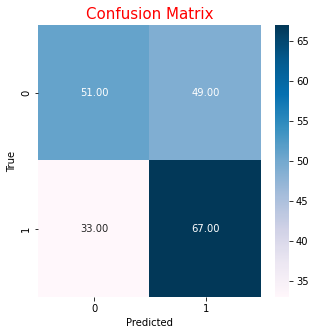

AUC: 0.6313000000000001


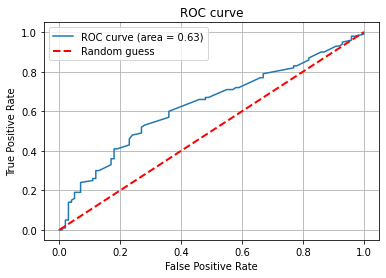

Step:  12
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          1   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          1   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          1   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          0   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          0   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          0   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          1   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          1   

     log odd score  
0         9.230241  
1         9.230241  
2         9.23

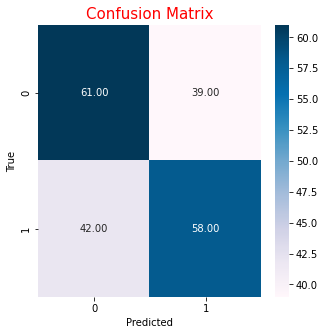

AUC: 0.61875


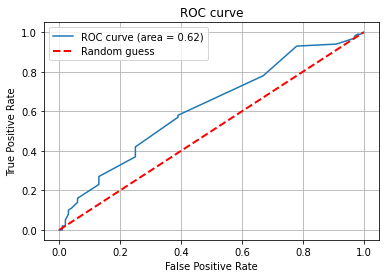

Step:  13
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          0   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          0   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          1   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          0   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          0   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          0   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          0   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          1   

     log odd score  
0        -4.615121  
1         0.000000  
2         4.61

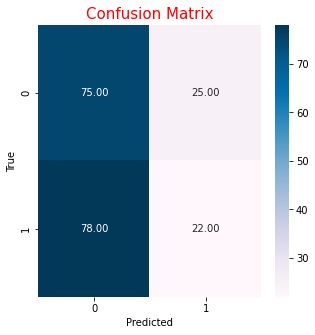

AUC: 0.5163000000000001


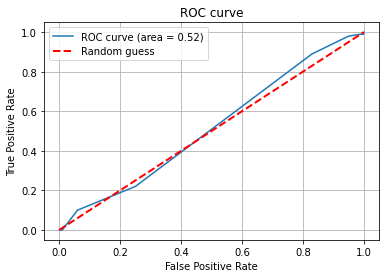

Step:  14
                                                   seq  Bound  predicted  \
0    TCAGTCAGGGTAAGCCGTACATCGAATTGCGTAGAGTAGACTTCCA...      1          0   
1    CGTTCATGGTGGCTAGTAAGCCTCTCATTCTATTTCATCATAACTT...      1          0   
2    AGTCTCTGATTGAAGCAGAACGCAACCTCATGGTATCCTCGAAGAG...      1          0   
3    AGTGGCTCTTTTCGTTAACGAGATAAAGCCCTGCGGCCTTACCAGA...      0          0   
4    CCTACTGGGTTCGCAAACGAACCGAACCGTAATGTCGCGCTGTGTC...      1          0   
..                                                 ...    ...        ...   
195  CGTCGAGTAAGGGGAATTGCTGGTGCACGGATCGCTAACCTTTATC...      0          0   
196  TTCTGTAAGTGCATCGACTGCAACCCTTATCCGATCTTGCGCTCTA...      0          0   
197  AAGTCGATTACCGAGGCCATTATTGCGGCGAGTGACCCCGCGCTTA...      0          0   
198  CAAGCTTACGCGACGGTTGGGGGGTACATGTCTGCGTCCGGTTCTG...      1          0   
199  GGGGCTGAACTGTATGGCTTCAATAGTTCTTACATTAAGAAGCGGT...      1          0   

     log odd score  
0         0.000000  
1         0.000000  
2         0.00

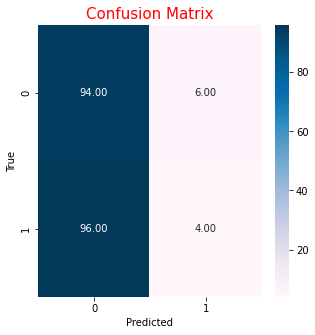

AUC: 0.49555


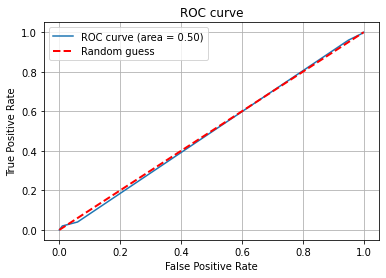

In [2]:
colnames2 = ["FoldID", "EventID", "start_index", "seq", "Bound"]
colnames = ["FoldID", "EventID", "seq", "Bound"]

#df =  motif 
#df2 = non motif
#df4 = mixed test file
df = pd.read_csv('/content/test1/motif.txt', delimiter="\t")

df2 = pd.read_csv('/content/test1/nonmotif.txt', delimiter="\t")
df1 = list(df["seq"])
df3 = list(df2["seq"])
#df1.reset_index(drop=True, inplace=True)
#df3.reset_index(drop=True, inplace=True)
#df4 = pd.read_csv('/content/test1/mixed.txt', delimiter="\t")

#df4=df4.rename(columns=df4.iloc[0]).drop(df4.index[0])
#df4 = df4.sample(frac=1).reset_index(drop=True)
print('##### df head #####')
#print(df4.head())

motif_seq = df['seq'].to_list()
nonmotif_seq = df2['seq'].to_list()
print("Len of motif list: ", len(motif_seq))
print("Len of non motif list: ", len(nonmotif_seq))
X_motifs = motif_seq
y_motifs = [1 for i in range(len(motif_seq))]

X_nonmotifs = nonmotif_seq
y_nonmotifs = [0 for i in range(len(nonmotif_seq))]

kf = KFold(n_splits=10)
print(kf.get_n_splits(X_motifs))

all_train_index_motif, all_test_index_motif  = [], []
all_train_index_nonmotif, all_test_index_nonmotif  = [], []

#motif
for train_index, test_index in kf.split(X_motifs): 
  #print("TRAIN: ", train_index, "TEST: ", test_index)
  all_train_index_motif.append(train_index)
  all_test_index_motif.append(test_index)

#nonmotif
for train_index, test_index in kf.split(X_nonmotifs): 
  #print("TRAIN: ", train_index, "TEST: ", test_index)
  all_train_index_nonmotif.append(train_index)
  all_test_index_nonmotif.append(test_index)

print('##### len(all_train_index_motif[0]) #####')
print(len(all_train_index_motif[0]))
print('##### len(all_train_index_motif) #####')
print(len(all_train_index_motif))
print('##### len(all_train_index_nonmotif) #####')
print(len(all_train_index_nonmotif))
print('##### all_train_index_nonmotif[0] #####')
print(len(all_train_index_nonmotif[0]))
print('##### all_test_index_nonmotif #####')
print(len(all_test_index_nonmotif))
print('##### all_test_index_motif[0]) #####')
print(len(all_test_index_motif[0]))

#K FOLD loop - for the number of folds 
for i in range(kf.n_splits):
  l_motif=[]
  l_nonmotif=[]

  motif_seq=[]
  for a in all_train_index_motif[i]:
    motif_seq.append(X_motifs[a])

  nonmotif_seq=[]
  for a1 in all_train_index_nonmotif[i]:
    nonmotif_seq.append(X_nonmotifs[a1])
  

  for j in range(len(all_test_index_motif[0])):
    test_set_motif=X_motifs
    l_motif.append(X_motifs[all_test_index_motif[i][j]])

    test_set_nonmotif=X_nonmotifs
    l_nonmotif.append(X_nonmotifs[all_test_index_nonmotif[i][j]])

  l_1 =[1 for i in range(len(l_motif))]
  l_0 =[0 for i in range(len(l_nonmotif))]

  df_test= pd.DataFrame(list(zip(l_motif,l_1)),columns=['seq','Bound'])
  extra={'seq':l_nonmotif,'Bound':l_0}
  df_test= df_test.append(pd.DataFrame(extra))
  df_test=df_test.sample(frac=1).reset_index(drop=True)
  #print(df_test)

#training loop: 
  for i1 in range(2,15,1): #order of the markov models
    print("Step: ", i1)
    var = i1
    dict6 = train(motif_seq,nonmotif_seq,df_test)
    #print("dict6",dict6)
    acc = accuracy(df_test)
    print(acc)  
    y_true,y_pred = acc_score(df_test)
    confusion_mat(y_true,y_pred)
    #auc_calculate(df_test)
    roc_calculate(df_test)